In [1]:
import sys
sys.path.append(".")
sys.path.append("..")
sys.path.append("../..")

In [2]:
from PIL import Image
import torch
import numpy as np
import matplotlib.pyplot as plt
from utils.image_utils import *
from model.my_diffusers.models import AutoencoderKL_Pretrained 
import trimesh
import os 
import torch.nn.functional as F
from typing import Sequence, Union

os.environ["OPENCV_IO_ENABLE_OPENEXR"]="1"

import cv2

In [3]:
def np2th(ndarray):
    if isinstance(ndarray, torch.Tensor):
        return ndarray.detach().cpu()
    elif isinstance(ndarray, np.ndarray):
        return torch.tensor(ndarray).float()
    else:
        raise ValueError("Input should be either torch.Tensor or np.ndarray")

def th2np(tensor):
    if isinstance(tensor, np.ndarray):
        return tensor
    if isinstance(tensor, torch.Tensor):
        return tensor.detach().cpu().numpy()

        
def normalize_points(p, method: str="sphere"):
    if method == "sphere":
        return _to_unit_sphere(p)
    elif method == "cube":
        return _to_unit_cube(p)
    else:
        raise AssertionError

def _to_unit_sphere(pc: Union[np.ndarray, torch.Tensor]):
    """
    pc: [B,N,3] or [N,3]
    """
    dtype = type(pc)
    pc = np2th(pc)
    shapes = pc.shape
    N = shapes[-2]
    pc = pc.reshape(-1, N, 3)
    m = pc.mean(1, keepdim=True)
    pc = pc - m
    s = torch.max(torch.sqrt(torch.sum(pc**2, -1, keepdim=True)), 1, keepdim=True)[0]
    pc = pc / s
    pc = pc.reshape(shapes)
    if dtype == np.ndarray:
        return th2np(pc)
    return pc

In [4]:
device = torch.device('cuda:7') if torch.cuda.is_available() else torch.device('cpu')

In [5]:
import datetime
import time
import traceback
from pathlib import Path
from typing import Tuple, Optional

import numpy
import skimage.io
import torch
import torch.nn.functional as F

import Imath
import OpenEXR


class Warper:
    def __init__(self, resolution: tuple = None, device: int = 0):
        self.device = device
        self.resolution = resolution
        return

    def forward_warp(self, 
                     frame1: torch.Tensor, 
                     mask1: Optional[torch.Tensor], 
                     depth1: torch.Tensor,
                     transformation1: torch.Tensor, 
                     transformation2: torch.Tensor, 
                     intrinsic1: torch.Tensor, 
                     intrinsic2: Optional[torch.Tensor],
                     render_method: str = "splatting",
                     debug_mode: bool = False) -> \
            Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        
        """
         Given a frame1 and global transformations transformation1 and transformation2, 
         warps frame1 to next view using bilinear splatting.
        
         All arrays should be torch tensors with batch dimension and channel first
         :param frame1: (b, 3, h, w). If frame1 is not in the range [-1, 1], either set is_image=False when calling
                        bilinear_splatting on frame within this function, or modify clipping in bilinear_splatting()
                        method accordingly.
         :param mask1: (b, 1, h, w) - 1 for known, 0 for unknown. Optional
         :param depth1: (b, 1, h, w)
         :param transformation1: (b, 4, 4) extrinsic transformation matrix of first view: [R, t; 0, 1]
         :param transformation2: (b, 4, 4) extrinsic transformation matrix of second view: [R, t; 0, 1]
         :param intrinsic1: (b, 3, 3) camera intrinsic matrix
         :param intrinsic2: (b, 3, 3) camera intrinsic matrix. Optional
        """
        print("frame1", frame1.shape)
        
        if self.resolution is not None:
            assert frame1.shape[2:4] == self.resolution
        b, c, h, w = frame1.shape
        if mask1 is None:
            mask1 = torch.ones(size=(b, 1, h, w)).to(frame1)
        if intrinsic2 is None:
            intrinsic2 = intrinsic1.clone()
        
        assert frame1.shape == (b, 3, h, w)
        assert mask1.shape == (b, 1, h, w)
        assert depth1.shape == (b, 1, h, w)
        assert transformation1.shape == (b, 4, 4)
        assert transformation2.shape == (b, 4, 4)
        assert intrinsic1.shape == (b, 3, 3)
        assert intrinsic2.shape == (b, 3, 3)

        frame1 = frame1.to(self.device)
        mask1 = mask1.to(self.device)
        depth1 = depth1.to(self.device)
        transformation1 = transformation1.to(self.device)
        transformation2 = transformation2.to(self.device)
        intrinsic1 = intrinsic1.to(self.device)
        intrinsic2 = intrinsic2.to(self.device)

        # Backproject source grid into target grid
        # trans_points1 (b, h, w, 3, 1) holds warped 2D homogeneous coordinates
        return_dict = self.compute_transformed_points(depth1,
                                                      transformation1,
                                                      transformation2,
                                                      intrinsic1,
                                                      intrinsic2,
                                                      normalized_coordinates=False)
            
        trans_points1 = return_dict["trans_norm_points"]
        if debug_mode:
            debugging_trans_norm_points = return_dict["debugging_trans_norm_points"] # Single point
            print("DEBUG", (debugging_trans_norm_points[:, :, :, :2, 0] / debugging_trans_norm_points[:, :, :, 2:3, 0])[0][400][400])
            
                
        # Homogeneous coordinates to u, v coordinates
        # Jaihoon
        trans_coordinates = trans_points1[:, :, :, :2, 0] / trans_points1[:, :, :, 2:3, 0]
        print("uv space - trans_coordinates", trans_coordinates.shape, trans_coordinates[0][400][400], trans_coordinates[0][450][450], trans_coordinates[0][450][400])

        trans_depth1 = trans_points1[:, :, :, 2, 0][:, None] # b 1 h w
        print("trans_points1", trans_points1.shape, "trans_depth1", trans_depth1.shape)
        """
        grid format
            [[[0, 0], [1, 0], ...],
             [[1, 0], [1, 1], ...]] : [x, y]
        """
        # 2023.07.27 Jaihoon
        grid = self.create_grid(b, h, w, normalized_coordinates=False).to(trans_coordinates)
        grid = grid.permute(0, 2, 3, 1)
        
        print("flow12", trans_coordinates.shape, trans_coordinates[0][300][300], trans_coordinates[0][300][301])
        # Source view -> Target view displacement 
        flow12 = trans_coordinates - grid
        flow12 = flow12.permute(0, 3, 1, 2)         # 2023.07.27 Jaihoon
        
        if render_method == "splatting":
            print(f"rendering method splatting")
            warped_frame2, mask2 = self.bilinear_splatting(frame1, 
                                                           mask1, 
                                                           trans_depth1, 
                                                           flow12, 
                                                           None, 
                                                           is_image=True)
        elif render_method == "interpolation":
            print(f"rendering method interpolation")
            warped_frame2, mask2 = self.bilinear_interpolation(frame1, 
                                                               mask1, 
                                                               flow12,
                                                               flow12_mask=None,
                                                               is_image=True)
        elif render_method == "nearest":
            raise NotImplementedError(f"Not implemented method {render_method}")
            print(f"rendering method nearest")
            warped_frame2 = self.nearest_interpolation(frame1, 
                                                       mask1, 
                                                       flow12,
                                                       flow12_mask=None,
                                                       is_image=True)
        
        else:
            raise NotImplementedError(f"Not implemented method {render_method}")
        
        # Jaihoon
#         warped_depth2 = self.bilinear_splatting(trans_depth1[:, :, None],
        warped_depth2 = self.bilinear_splatting(depth1,
                                                mask1, 
                                                trans_depth1, 
                                                flow12, 
                                                None,
                                                is_image=False)[0]
        
        return warped_frame2, mask2, warped_depth2, flow12
    
    
    def unnormalize(self, b, h, w, tensor):
        tensor[..., 0] = (tensor[..., 0] + 1) * (w-1) / 2
        tensor[..., 1] = (tensor[..., 1] + 1) * (h-1) / 2
        
        return tensor
    

    def compute_transformed_points(self, 
                                   depth1: torch.Tensor, 
                                   transformation1: torch.Tensor, 
                                   transformation2: torch.Tensor,
                                   intrinsic1: torch.Tensor, 
                                   intrinsic2: Optional[torch.Tensor],
                                   normalized_coordinates: bool = False,
                                   debug_mode: bool = False):
        
        """
        Computes transformed position for each pixel location
        :param depth1: (b, 1, h, w)
        :param transformation1: (b, 4, 4)
        :param transformation2: (b, 4, 4)
        :param intrinsic1: (b, 3, 3)
        :param intrinsic2: (b, 3, 3)
        """
        
        if self.resolution is not None:
            assert depth1.shape[2:4] == self.resolution
        b, _, h, w = depth1.shape
        if intrinsic2 is None:
            intrinsic2 = intrinsic1.clone()
        transformation = torch.bmm(transformation2, torch.linalg.inv(transformation1))  # (b, 4, 4)
        
        if normalized_coordinates:
            x1d = torch.linspace(-1, 1, w)[None]
            y1d = torch.linspace(-1, 1, h)[:, None]

        else:
            # Compute source grid points in homogeneous coordinate system
            x1d = torch.arange(0, w)[None]
            # Jaihoon
            y1d = torch.arange(0, h)[:, None]
    #         y1d = -torch.arange(0, h)[:, None]        
    
        x2d = x1d.repeat([h, 1]).to(depth1)  # (h, w)
        y2d = y1d.repeat([1, w]).to(depth1)  # (h, w)

        ones_2d = torch.ones(size=(h, w)).to(depth1)  # (h, w)
        ones_4d = ones_2d[None, :, :, None, None].repeat([b, 1, 1, 1, 1])  # (b, h, w, 1, 1)
        # Jaihoon
        pos_vectors_homo = torch.stack([x2d, y2d, ones_2d], dim=2)[None, :, :, :, None]  # (1, h, w, 3, 1)
        
        # Jaihoon : Debugging purpose
        if debug_mode:
            debug_x = torch.ones_like(x2d) * (w // 2)
            debug_y = torch.ones_like(y2d) * (h // 2)
            debugging_grid = torch.stack([debug_x, debug_y, ones_2d], dim=2)[None, :, :, :, None]        
        
#         pos_vectors_homo = torch.stack([x2d, y2d, -ones_2d], dim=2)[None, :, :, :, None]  # (1, h, w, 3, 1)
        print("pos_vectors_homo", pos_vectors_homo.shape, pos_vectors_homo[0][400][400], pos_vectors_homo[0][450][450], pos_vectors_homo[0][450][400])

        # Compute projective transformation from source to target view
        intrinsic1_inv = torch.linalg.inv(intrinsic1)  # (b, 3, 3)
        intrinsic1_inv_4d = intrinsic1_inv[:, None, None]  # (b, 1, 1, 3, 3)
        intrinsic2_4d = intrinsic2[:, None, None]  # (b, 1, 1, 3, 3)
        depth_4d = depth1[:, 0][:, :, :, None, None]  # (b, h, w, 1, 1)
        trans_4d = transformation[:, None, None]  # (b, 1, 1, 4, 4)
        
        # Warp source grid into target grid, return warped 2D homogeneous coordinates
        unnormalized_pos = torch.matmul(intrinsic1_inv_4d, pos_vectors_homo)  # (b, h, w, 3, 1)
        print("unnormalized_pos", unnormalized_pos.shape, unnormalized_pos[0][400][400], unnormalized_pos[0][450][450], unnormalized_pos[0][450][400])
        foreground_mask = depth_4d != torch.max(depth_4d)
        foreground_mask_channel = torch.cat([foreground_mask, foreground_mask, foreground_mask], dim=-2)
        world_points = depth_4d * unnormalized_pos  # (b, h, w, 3, 1)
        
        print("world_points center", torch.mean(world_points[foreground_mask_channel].reshape(-1, 3), dim=0))
        print("Max depth", torch.max(depth_4d[foreground_mask]), "Min depth", torch.min(depth_4d[foreground_mask]))
        
        world_points_homo = torch.cat([world_points, ones_4d], dim=3)  # (b, h, w, 4, 1)
        print("world_points_homo", world_points_homo.shape, world_points_homo[0][400][400], world_points_homo[0][450][450], world_points_homo[0][450][400])
        print("T2 T1.inv", trans_4d[0][0][0])
        trans_world_homo = torch.matmul(trans_4d, world_points_homo)  # (b, h, w, 4, 1)
        print("trans_world_homo", trans_world_homo[0][400][400], trans_world_homo[0][450][450], trans_world_homo[0][450][400])
        trans_world = trans_world_homo[:, :, :, :3]  # (b, h, w, 3, 1)
        trans_norm_points = torch.matmul(intrinsic2_4d, trans_world)  # (b, h, w, 3, 1)
        print("trans_norm_points", trans_norm_points[0][400][400], trans_norm_points[0][450][450], trans_norm_points[0][450][400])
        
        return_dict = {
            "trans_norm_points": trans_norm_points,
        }
            
        # Jaihoon Debugging
        if debug_mode:
            debugging_unnormalized_pos = torch.matmul(intrinsic1_inv_4d, debugging_grid)  # (b, h, w, 3, 1)
            print("debugging_unnormalized_pos", debugging_unnormalized_pos.shape, debugging_unnormalized_pos[0][400][400])
            debugging_world_points = depth_4d * debugging_unnormalized_pos
            debugging_world_points_homo = torch.cat([debugging_world_points, ones_4d], dim=3)
            print("debugging_world_points_homo", debugging_world_points_homo.shape, debugging_world_points_homo[0][400][400])
            debugging_trans_world_homo = torch.matmul(trans_4d, debugging_world_points_homo)
            print("debugging_trans_world_homo", debugging_trans_world_homo.shape, debugging_trans_world_homo[0][400][400])
            debugging_trans_world = debugging_trans_world_homo[:, :, :, :3]  # (b, h, w, 3, 1)
            print("debugging_trans_world", debugging_trans_world.shape, debugging_trans_world[0][400][400])
            debugging_trans_norm_points = torch.matmul(intrinsic2_4d, debugging_trans_world)
            print("debugging_trans_norm_points", debugging_trans_norm_points.shape, debugging_trans_norm_points[0][400][400])
        
        if debug_mode:
            return_dict["debugging_trans_norm_points"] = debugging_trans_norm_points
        
        return return_dict

    
    def bilinear_splatting(self, 
                           frame1: torch.Tensor, 
                           mask1: Optional[torch.Tensor], 
                           depth1: torch.Tensor,
                           flow12: torch.Tensor, 
                           flow12_mask: Optional[torch.Tensor], 
                           is_image: bool = False) -> \
            Tuple[torch.Tensor, torch.Tensor]:
        
        """
        Bilinear splatting
        :param frame1: (b,c,h,w)
        :param mask1: (b,1,h,w): 1 for known, 0 for unknown. Optional
        :param depth1: (b,1,h,w)
        :param flow12: (b,2,h,w)
        :param flow12_mask: (b,1,h,w): 1 for valid flow, 0 for invalid flow. Optional
        :param is_image: if true, output will be clipped to (-1,1) range
        :return: warped_frame2: (b,c,h,w)
                 mask2: (b,1,h,w): 1 for known and 0 for unknown
        """
        
        if self.resolution is not None:
            assert frame1.shape[2:4] == self.resolution
        b, c, h, w = frame1.shape
        
        if mask1 is None:
            mask1 = torch.ones(size=(b, 1, h, w)).to(frame1)
            
        if flow12_mask is None:
            flow12_mask = torch.ones(size=(b, 1, h, w)).to(flow12)
        
        # Compute relative weight to the closest grid 
        grid = self.create_grid(b, h, w).to(frame1)
        trans_pos = flow12 + grid

        trans_pos_offset = trans_pos + 1
        trans_pos_floor = torch.floor(trans_pos_offset).long()
        trans_pos_ceil = torch.ceil(trans_pos_offset).long()
        
        trans_pos_offset = torch.stack([
            torch.clamp(trans_pos_offset[:, 0], min=0, max=w + 1),
            torch.clamp(trans_pos_offset[:, 1], min=0, max=h + 1)], dim=1)
        
        trans_pos_floor = torch.stack([
            torch.clamp(trans_pos_floor[:, 0], min=0, max=w + 1),
            torch.clamp(trans_pos_floor[:, 1], min=0, max=h + 1)], dim=1)
        
        trans_pos_ceil = torch.stack([
            torch.clamp(trans_pos_ceil[:, 0], min=0, max=w + 1),
            torch.clamp(trans_pos_ceil[:, 1], min=0, max=h + 1)], dim=1)
        
        prox_weight_nw = (1 - (trans_pos_offset[:, 1:2] - trans_pos_floor[:, 1:2])) * \
                         (1 - (trans_pos_offset[:, 0:1] - trans_pos_floor[:, 0:1]))
        
        prox_weight_sw = (1 - (trans_pos_ceil[:, 1:2] - trans_pos_offset[:, 1:2])) * \
                         (1 - (trans_pos_offset[:, 0:1] - trans_pos_floor[:, 0:1]))
        
        prox_weight_ne = (1 - (trans_pos_offset[:, 1:2] - trans_pos_floor[:, 1:2])) * \
                         (1 - (trans_pos_ceil[:, 0:1] - trans_pos_offset[:, 0:1]))
        
        prox_weight_se = (1 - (trans_pos_ceil[:, 1:2] - trans_pos_offset[:, 1:2])) * \
                         (1 - (trans_pos_ceil[:, 0:1] - trans_pos_offset[:, 0:1]))

        sat_depth1 = torch.clamp(depth1, min=0, max=1000)
        log_depth1 = torch.log(1 + sat_depth1)
        depth_weights = torch.exp(log_depth1 / log_depth1.max() * 50)
        
        # Attenuate weight by depth value
        weight_nw = torch.moveaxis(prox_weight_nw * mask1 * flow12_mask / depth_weights, [0, 1, 2, 3], [0, 3, 1, 2])
        weight_sw = torch.moveaxis(prox_weight_sw * mask1 * flow12_mask / depth_weights, [0, 1, 2, 3], [0, 3, 1, 2])
        weight_ne = torch.moveaxis(prox_weight_ne * mask1 * flow12_mask / depth_weights, [0, 1, 2, 3], [0, 3, 1, 2])
        weight_se = torch.moveaxis(prox_weight_se * mask1 * flow12_mask / depth_weights, [0, 1, 2, 3], [0, 3, 1, 2])

        warped_frame = torch.zeros(size=(b, h + 2, w + 2, c), dtype=torch.float32).to(frame1)
        warped_weights = torch.zeros(size=(b, h + 2, w + 2, 1), dtype=torch.float32).to(frame1)
        
        frame1_cl = torch.moveaxis(frame1, [0, 1, 2, 3], [0, 3, 1, 2])
        batch_indices = torch.arange(b)[:, None, None].to(frame1.device)
                
        warped_frame.index_put_((batch_indices,
                                 trans_pos_floor[:, 1], 
                                 trans_pos_floor[:, 0]),
                                 frame1_cl * weight_nw, 
                                 accumulate=True)
        
        warped_frame.index_put_((batch_indices, 
                                 trans_pos_ceil[:, 1], 
                                 trans_pos_floor[:, 0]),
                                 frame1_cl * weight_sw, 
                                 accumulate=True)
        
        warped_frame.index_put_((batch_indices, 
                                 trans_pos_floor[:, 1], 
                                 trans_pos_ceil[:, 0]),
                                 frame1_cl * weight_ne, 
                                 accumulate=True)
        
        warped_frame.index_put_((batch_indices, 
                                 trans_pos_ceil[:, 1], 
                                 trans_pos_ceil[:, 0]),
                                 frame1_cl * weight_se, 
                                 accumulate=True)

        warped_weights.index_put_((batch_indices, 
                                   trans_pos_floor[:, 1], 
                                   trans_pos_floor[:, 0]),
                                   weight_nw, 
                                   accumulate=True)
        
        warped_weights.index_put_((batch_indices, 
                                   trans_pos_ceil[:, 1], 
                                   trans_pos_floor[:, 0]),
                                   weight_sw, 
                                   accumulate=True)
        
        warped_weights.index_put_((batch_indices, 
                                   trans_pos_floor[:, 1], 
                                   trans_pos_ceil[:, 0]),
                                   weight_ne, 
                                   accumulate=True)
        
        warped_weights.index_put_((batch_indices, 
                                   trans_pos_ceil[:, 1], 
                                   trans_pos_ceil[:, 0]),
                                   weight_se,
                                   accumulate=True)

        warped_frame_cf = torch.moveaxis(warped_frame, [0, 1, 2, 3], [0, 2, 3, 1])
        warped_weights_cf = torch.moveaxis(warped_weights, [0, 1, 2, 3], [0, 2, 3, 1])
        cropped_warped_frame = warped_frame_cf[:, :, 1:-1, 1:-1]
        cropped_weights = warped_weights_cf[:, :, 1:-1, 1:-1]

        mask = cropped_weights > 0
        zero_value = 0
        zero_tensor = torch.tensor(zero_value, dtype=frame1.dtype, device=frame1.device)
        warped_frame2 = torch.where(mask, cropped_warped_frame / cropped_weights, zero_tensor)
        mask2 = mask.to(frame1)

        if is_image:
            assert warped_frame2.min() >= -1.1  # Allow for rounding errors
            assert warped_frame2.max() <= 1.1
            warped_frame2 = torch.clamp(warped_frame2, min=0, max=1)
            
        return warped_frame2, mask2
    

    def bilinear_interpolation(self, 
                               frame2: torch.Tensor, 
                               mask2: Optional[torch.Tensor], 
                               flow12: torch.Tensor,
                               flow12_mask: Optional[torch.Tensor], 
                               is_image: bool = False) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Bilinear interpolation
        :param frame2: (b, c, h, w)
        :param mask2: (b, 1, h, w): 1 for known, 0 for unknown. Optional
        :param flow12: (b, 2, h, w)
        :param flow12_mask: (b, 1, h, w): 1 for valid flow, 0 for invalid flow. Optional
        :param is_image: if true, output will be clipped to (-1,1) range
        :return: warped_frame1: (b, c, h, w)
                 mask1: (b, 1, h, w): 1 for known and 0 for unknown
        """
        
        if self.resolution is not None:
            assert frame2.shape[2:4] == self.resolution
        b, c, h, w = frame2.shape
        
        if mask2 is None:
            mask2 = torch.ones(size=(b, 1, h, w)).to(frame2)
            
        if flow12_mask is None:
            flow12_mask = torch.ones(size=(b, 1, h, w)).to(flow12)
            
        grid = self.create_grid(b, h, w).to(frame2)
        trans_pos = flow12 + grid

        trans_pos_offset = trans_pos + 1
        trans_pos_floor = torch.floor(trans_pos_offset).long()
        trans_pos_ceil = torch.ceil(trans_pos_offset).long()
        
        trans_pos_offset = torch.stack([
            torch.clamp(trans_pos_offset[:, 0], min=0, max=w + 1),
            torch.clamp(trans_pos_offset[:, 1], min=0, max=h + 1)], dim=1)
        
        trans_pos_floor = torch.stack([
            torch.clamp(trans_pos_floor[:, 0], min=0, max=w + 1),
            torch.clamp(trans_pos_floor[:, 1], min=0, max=h + 1)], dim=1)
        
        trans_pos_ceil = torch.stack([
            torch.clamp(trans_pos_ceil[:, 0], min=0, max=w + 1),
            torch.clamp(trans_pos_ceil[:, 1], min=0, max=h + 1)], dim=1)

        prox_weight_nw = (1 - (trans_pos_offset[:, 1:2] - trans_pos_floor[:, 1:2])) * \
                         (1 - (trans_pos_offset[:, 0:1] - trans_pos_floor[:, 0:1]))
        prox_weight_sw = (1 - (trans_pos_ceil[:, 1:2] - trans_pos_offset[:, 1:2])) * \
                         (1 - (trans_pos_offset[:, 0:1] - trans_pos_floor[:, 0:1]))
        prox_weight_ne = (1 - (trans_pos_offset[:, 1:2] - trans_pos_floor[:, 1:2])) * \
                         (1 - (trans_pos_ceil[:, 0:1] - trans_pos_offset[:, 0:1]))
        prox_weight_se = (1 - (trans_pos_ceil[:, 1:2] - trans_pos_offset[:, 1:2])) * \
                         (1 - (trans_pos_ceil[:, 0:1] - trans_pos_offset[:, 0:1]))

        weight_nw = torch.moveaxis(prox_weight_nw * flow12_mask, [0, 1, 2, 3], [0, 3, 1, 2])
        weight_sw = torch.moveaxis(prox_weight_sw * flow12_mask, [0, 1, 2, 3], [0, 3, 1, 2])
        weight_ne = torch.moveaxis(prox_weight_ne * flow12_mask, [0, 1, 2, 3], [0, 3, 1, 2])
        weight_se = torch.moveaxis(prox_weight_se * flow12_mask, [0, 1, 2, 3], [0, 3, 1, 2])

        frame2_offset = F.pad(frame2, [1, 1, 1, 1])
        mask2_offset = F.pad(mask2, [1, 1, 1, 1])
        bi = torch.arange(b)[:, None, None]

        f2_nw = frame2_offset[bi, :, trans_pos_floor[:, 1], trans_pos_floor[:, 0]]
        f2_sw = frame2_offset[bi, :, trans_pos_ceil[:, 1], trans_pos_floor[:, 0]]
        f2_ne = frame2_offset[bi, :, trans_pos_floor[:, 1], trans_pos_ceil[:, 0]]
        f2_se = frame2_offset[bi, :, trans_pos_ceil[:, 1], trans_pos_ceil[:, 0]]

        m2_nw = mask2_offset[bi, :, trans_pos_floor[:, 1], trans_pos_floor[:, 0]]
        m2_sw = mask2_offset[bi, :, trans_pos_ceil[:, 1], trans_pos_floor[:, 0]]
        m2_ne = mask2_offset[bi, :, trans_pos_floor[:, 1], trans_pos_ceil[:, 0]]
        m2_se = mask2_offset[bi, :, trans_pos_ceil[:, 1], trans_pos_ceil[:, 0]]

        nr = weight_nw * f2_nw * m2_nw + weight_sw * f2_sw * m2_sw + \
             weight_ne * f2_ne * m2_ne + weight_se * f2_se * m2_se
        dr = weight_nw * m2_nw + weight_sw * m2_sw + weight_ne * m2_ne + weight_se * m2_se

        zero_value = -1 if is_image else 0
        zero_tensor = torch.tensor(zero_value, dtype=nr.dtype, device=nr.device)
        warped_frame1 = torch.where(dr > 0, nr / dr, zero_tensor)
        mask1 = (dr > 0).to(frame2)

        # Convert to channel first
        warped_frame1 = torch.moveaxis(warped_frame1, [0, 1, 2, 3], [0, 2, 3, 1])
        mask1 = torch.moveaxis(mask1, [0, 1, 2, 3], [0, 2, 3, 1])

        if is_image:
            assert warped_frame1.min() >= -1.1  # Allow for rounding errors
            assert warped_frame1.max() <= 1.1
            warped_frame1 = torch.clamp(warped_frame1, min=0, max=1)
            
        return warped_frame1, mask1


    @staticmethod
    def create_grid(batch, height, width, normalized_coordinates=False):
        if normalized_coordinates:
            xs = torch.linspace(-1, 1, width)
            ys = torch.linspace(-1, 1, height)
        else:
            xs = torch.linspace(0, width - 1, width)
            ys = torch.linspace(0, height - 1, height)
#             x_1d = torch.arange(0, w)[None]
#             y_1d = torch.arange(0, h)[:, None]
#             x_2d = x_1d.repeat([h, 1])
#             y_2d = y_1d.repeat([1, w])
#             grid = torch.stack([x_2d, y_2d], dim=0)

        base_grid = torch.stack(torch.meshgrid([xs, ys])).transpose(1, 2)  # 2xHxW
        base_grid = base_grid[None]
        
#         print(base_grid.shape)
        
#             batch_grid = grid[None].repeat([b, 1, 1, 1])
        
        return base_grid

    @staticmethod
    def read_image(path: Path) -> torch.Tensor:
        image = skimage.io.imread(path.as_posix())
        return image

    @staticmethod
    def read_depth(path: Path) -> torch.Tensor:
        if path.suffix == '.png':
            depth = skimage.io.imread(path.as_posix())
        elif path.suffix == '.npy':
            depth = numpy.load(path.as_posix())
        elif path.suffix == '.npz':
            with numpy.load(path.as_posix()) as depth_data:
                depth = depth_data['depth']
        elif path.suffix == '.exr':
            exr_file = OpenEXR.InputFile(path.as_posix())
            raw_bytes = exr_file.channel('B', Imath.PixelType(Imath.PixelType.FLOAT))
            depth_vector = numpy.frombuffer(raw_bytes, dtype=numpy.float32)
            height = exr_file.header()['displayWindow'].max.y + 1 - exr_file.header()['displayWindow'].min.y
            width = exr_file.header()['displayWindow'].max.x + 1 - exr_file.header()['displayWindow'].min.x
            depth = numpy.reshape(depth_vector, (height, width))
        else:
            raise RuntimeError(f'Unknown depth format: {path.suffix}')
        return depth


def demo1(frame1_path, depth1_path, transformation1, transformation2):
    warper = Warper(device=device)
    frame1 = Image.open(frame1_path).convert("RGB")
    frame1 = (np.array(frame1) / 255.0).astype(np.float32)
    frame1 = torch.tensor(frame1).permute(2, 0, 1).unsqueeze(0)
    
    depth1 = torch.from_numpy(warper.read_depth(depth1_path))[None, None, :, :]
    # Jaihoon Debugging numpy 
#     depth1 = np.load(depth1_path)
    depth1 = torch.tensor(depth1)[None, None, :, :]
    print(depth1.shape, torch.max(depth1), torch.min(depth1))
    
    mask1 = depth1 != torch.max(depth1)
    print("mask1", mask1.shape)
#     depth1[mask1] = (depth1[mask1] - torch.min(depth1[mask1])) / (torch.max(depth1[mask1]) - torch.min(depth1[mask1]))
    
    batch_size, _, height_src, width_src = frame1.shape
    FOV = 60
    focal = (height_src / 2.0) / np.tan(np.deg2rad(FOV / 2.0))
    cx, cy = width_src // 2, height_src // 2
    intrinsic = torch.FloatTensor([[[focal, 0,  cx],
                                    [0, focal, cy],
                                    [0,   0,    1]]])
    intrinsic = intrinsic.expand(batch_size, -1, -1)

    warped_frame2, mask2, warped_depth2, flow12 = warper.forward_warp(frame1, 
                                                                      mask1, 
                                                                      depth1, 
                                                                      transformation1, 
                                                                      transformation2, 
                                                                      intrinsic, 
                                                                      None,
                                                                      render_method="splatting")
    
    return frame1, warped_frame2, mask2, warped_depth2, flow12


from packaging import version as pver

def custom_meshgrid(*args):
    # ref: https://pytorch.org/docs/stable/generated/torch.meshgrid.html?highlight=meshgrid#torch.meshgrid
    if pver.parse(torch.__version__) < pver.parse('1.10'):
        return torch.meshgrid(*args)
    else:
        return torch.meshgrid(*args, indexing='ij')


In [6]:
def rand_pose2(radius=1, theta=None, phi=None, targets=0.0):
    batch_size = theta.shape[0]
    
    theta = torch.deg2rad(theta)
    phi = torch.deg2rad(phi)
    
    # Jaihoon 
    # Z-axis is positive since camera pose will be sampled centered on 3D point cloud which is +z axis 
    centers = torch.stack([radius * torch.sin(theta) * torch.sin(phi),
                           radius * torch.cos(theta),
                           -radius * torch.sin(theta) * torch.cos(phi)], dim=-1) # [B, 3]
        
    targets = targets.to(centers)
    centers += targets

    # lookat
    forward_vector = safe_normalize(targets - centers)
    up_vector = torch.FloatTensor([0, 1, 0]).to(device).unsqueeze(0).repeat(batch_size, 1)
    right_vector = safe_normalize(torch.cross(up_vector, forward_vector, dim=-1))
    
    up_vector = safe_normalize(torch.cross(forward_vector, right_vector, dim=-1))

    poses = torch.eye(4, dtype=torch.float, device=device).unsqueeze(0).repeat(batch_size, 1, 1) # Original
    poses[:, :3, :3] = torch.stack((right_vector, up_vector, forward_vector), dim=-1)
    # Jaihoon
    poses[:, :3, 3] = centers
    
    return poses
    

def safe_normalize(x, eps=1e-20):
    return x / torch.sqrt(torch.clamp(torch.sum(x * x, -1, keepdim=True), min=eps))


def inverse_mat(mat):
    rmat = mat[:, :3, :3]
    tvec = mat[:, :3, -1:]
    rmat_inv = torch.transpose(rmat, 1, 2)
    tvec_inv = rmat_inv.matmul(tvec)
    
    new_mat = torch.zeros_like(mat)
    new_mat[:, :3, :3] = rmat
    new_mat[:, :3, -1:] = tvec_inv
    
    return new_mat

In [9]:
# Zoom in and out

frame1_path = Path("/home/jh27kim/dataset/omniobject3d/OpenXD-OmniObject3D-New/raw/blender_renders/dinosaur/dinosaur_005/render/images/r_3.png")
depth1_path = Path("/home/jh27kim/dataset/omniobject3d/OpenXD-OmniObject3D-New/raw/blender_renders/dinosaur/dinosaur_005/render/depths/r_3_depth.exr")

phi_grid, theta_grid = np.array([0, 30, 60]), np.array([60, 90, 120])

obj_center = torch.tensor([0.0450, -0.0436,  3.9582])

# transformation1 = torch.FloatTensor([
#     [1, 0, 0, -obj_center[0]],
#     [0, 1, 0, -obj_center[1]],
#     [0, 0, 1, -obj_center[2]],
#     [0, 0, 0, 1],
# ]).unsqueeze(0)
transformation1 = torch.FloatTensor([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1],
]).unsqueeze(0)

rotated_img = []
rotated_depth = []

batch_size = 1
for phi_dl in phi_grid:
    for theta_dl in theta_grid:        
        transformation2 = rand_pose2(radius=torch.linalg.norm(obj_center).item(),
                                     theta=torch.FloatTensor([theta_dl]).to(device), 
                                     phi=torch.FloatTensor([phi_dl]).to(device),
                                     targets=obj_center)
        transformation2 = torch.linalg.inv(transformation2)
        
        frame1, warped_frame2, mask2, warped_depth2, flow12 = demo1(frame1_path, 
                                                                    depth1_path,
                                                                    transformation1, 
                                                                    transformation2)
        rotated_img.append(warped_frame2)
        rotated_depth.append(warped_depth2)
        

pos_vectors_homo torch.Size([1, 800, 800, 3, 1]) tensor([[400.],
        [400.],
        [  1.]], device='cuda:7') tensor([[450.],
        [450.],
        [  1.]], device='cuda:7') tensor([[400.],
        [450.],
        [  1.]], device='cuda:7')
unnormalized_pos torch.Size([1, 800, 800, 3, 1]) tensor([[0.],
        [0.],
        [1.]], device='cuda:7') tensor([[0.0722],
        [0.0722],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.0722],
        [1.0000]], device='cuda:7')
world_points center tensor([ 0.0450, -0.0436,  3.9582], device='cuda:7')
Max depth tensor(4.2188, device='cuda:7') Min depth tensor(3.8691, device='cuda:7')
world_points_homo torch.Size([1, 800, 800, 4, 1]) tensor([[0.0000],
        [0.0000],
        [3.8945],
        [1.0000]], device='cuda:7') tensor([[4.7273e+03],
        [4.7273e+03],
        [6.5504e+04],
        [1.0000e+00]], device='cuda:7') tensor([[0.0000],
        [0.3016],
        [4.1797],
        [1.0000]], device='cuda:7')
T2 T1.i

pos_vectors_homo torch.Size([1, 800, 800, 3, 1]) tensor([[400.],
        [400.],
        [  1.]], device='cuda:7') tensor([[450.],
        [450.],
        [  1.]], device='cuda:7') tensor([[400.],
        [450.],
        [  1.]], device='cuda:7')
unnormalized_pos torch.Size([1, 800, 800, 3, 1]) tensor([[0.],
        [0.],
        [1.]], device='cuda:7') tensor([[0.0722],
        [0.0722],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.0722],
        [1.0000]], device='cuda:7')
world_points center tensor([ 0.0450, -0.0436,  3.9582], device='cuda:7')
Max depth tensor(4.2188, device='cuda:7') Min depth tensor(3.8691, device='cuda:7')
world_points_homo torch.Size([1, 800, 800, 4, 1]) tensor([[0.0000],
        [0.0000],
        [3.8945],
        [1.0000]], device='cuda:7') tensor([[4.7273e+03],
        [4.7273e+03],
        [6.5504e+04],
        [1.0000e+00]], device='cuda:7') tensor([[0.0000],
        [0.3016],
        [4.1797],
        [1.0000]], device='cuda:7')
T2 T1.i

pos_vectors_homo torch.Size([1, 800, 800, 3, 1]) tensor([[400.],
        [400.],
        [  1.]], device='cuda:7') tensor([[450.],
        [450.],
        [  1.]], device='cuda:7') tensor([[400.],
        [450.],
        [  1.]], device='cuda:7')
unnormalized_pos torch.Size([1, 800, 800, 3, 1]) tensor([[0.],
        [0.],
        [1.]], device='cuda:7') tensor([[0.0722],
        [0.0722],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.0722],
        [1.0000]], device='cuda:7')
world_points center tensor([ 0.0450, -0.0436,  3.9582], device='cuda:7')
Max depth tensor(4.2188, device='cuda:7') Min depth tensor(3.8691, device='cuda:7')
world_points_homo torch.Size([1, 800, 800, 4, 1]) tensor([[0.0000],
        [0.0000],
        [3.8945],
        [1.0000]], device='cuda:7') tensor([[4.7273e+03],
        [4.7273e+03],
        [6.5504e+04],
        [1.0000e+00]], device='cuda:7') tensor([[0.0000],
        [0.3016],
        [4.1797],
        [1.0000]], device='cuda:7')
T2 T1.i

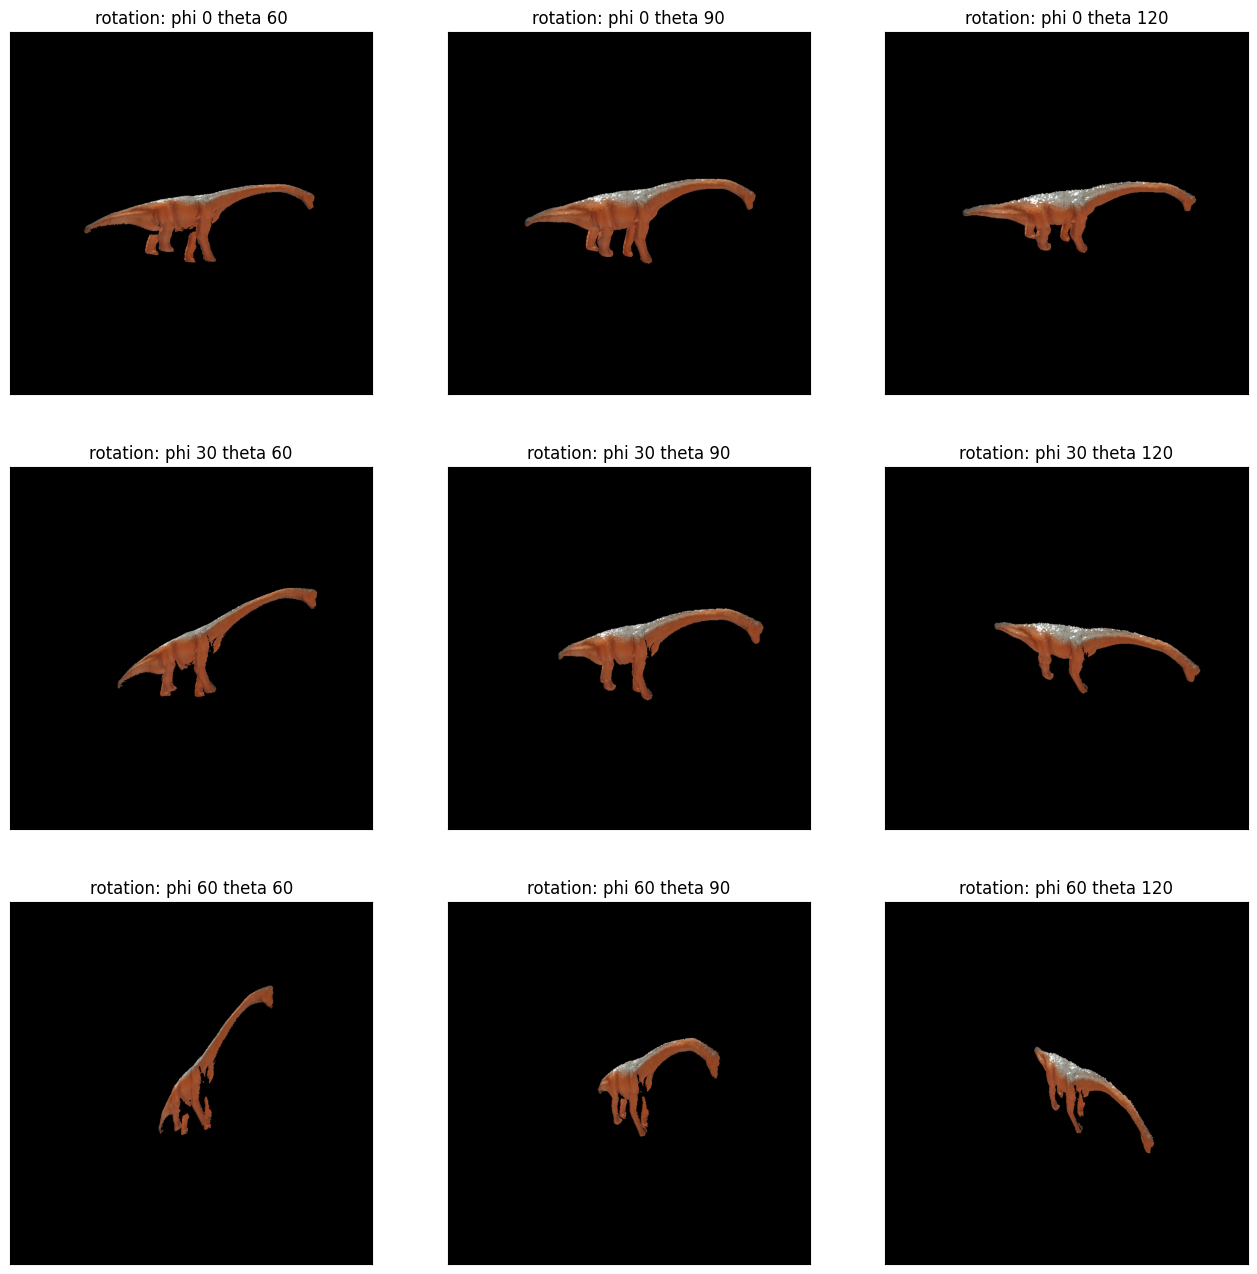

In [10]:
fig, axs = plt.subplots(3, 3, figsize=(16, 16))

axs = axs.flatten()
for i, (ax, img) in enumerate(zip(axs, rotated_img)):
    ax.imshow(torch_to_pil(img))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"rotation: phi {phi_grid[i // phi_grid.shape[0]]} theta {theta_grid[i % theta_grid.shape[0]]}")

In [17]:
# Zoom in and out

frame1_path = Path("/home/jh27kim/dataset/omniobject3d/OpenXD-OmniObject3D-New/raw/blender_renders/dinosaur/dinosaur_005/render/images/r_3.png")
depth1_path = Path("/home/jh27kim/dataset/omniobject3d/OpenXD-OmniObject3D-New/raw/blender_renders/dinosaur/dinosaur_005/render/depths/r_3_depth.exr")

x_grid, y_grid = np.array([-1, 0, 1]), np.array([-1, 0, 1])
obj_center = torch.tensor([0.0450, -0.0436,  3.9582])

transformation1 = torch.FloatTensor([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1],
]).unsqueeze(0)

translated_img = []
translated_depth = []

batch_size = 1
for dx in x_grid:
    for dy in y_grid:
        print("dx", dx, "dy", dy)
        transformation2 = torch.FloatTensor([
            [1, 0, 0, dx],
            [0, 1, 0, dy],
            [0, 0, 1, 0],
            [0, 0, 0, 1],
        ]).unsqueeze(0)
        transformation2 = torch.linalg.inv(transformation2)

        frame1, warped_frame2, mask2, warped_depth2, flow12 = demo1(frame1_path, 
                                                                    depth1_path,
                                                                    transformation1, 
                                                                    transformation2)
        translated_img.append(warped_frame2)
        translated_depth.append(warped_depth2)


dx -1 dy -1
pos_vectors_homo torch.Size([1, 800, 800, 3, 1]) tensor([[400.],
        [400.],
        [  1.]], device='cuda:7') tensor([[450.],
        [450.],
        [  1.]], device='cuda:7') tensor([[400.],
        [450.],
        [  1.]], device='cuda:7')
unnormalized_pos torch.Size([1, 800, 800, 3, 1]) tensor([[0.],
        [0.],
        [1.]], device='cuda:7') tensor([[0.0722],
        [0.0722],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.0722],
        [1.0000]], device='cuda:7')
world_points center tensor([ 0.0450, -0.0436,  3.9582], device='cuda:7')
Max depth tensor(4.2188, device='cuda:7') Min depth tensor(3.8691, device='cuda:7')
world_points_homo torch.Size([1, 800, 800, 4, 1]) tensor([[0.0000],
        [0.0000],
        [3.8945],
        [1.0000]], device='cuda:7') tensor([[4.7273e+03],
        [4.7273e+03],
        [6.5504e+04],
        [1.0000e+00]], device='cuda:7') tensor([[0.0000],
        [0.3016],
        [4.1797],
        [1.0000]], device='cuda

dx 0 dy 0
pos_vectors_homo torch.Size([1, 800, 800, 3, 1]) tensor([[400.],
        [400.],
        [  1.]], device='cuda:7') tensor([[450.],
        [450.],
        [  1.]], device='cuda:7') tensor([[400.],
        [450.],
        [  1.]], device='cuda:7')
unnormalized_pos torch.Size([1, 800, 800, 3, 1]) tensor([[0.],
        [0.],
        [1.]], device='cuda:7') tensor([[0.0722],
        [0.0722],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.0722],
        [1.0000]], device='cuda:7')
world_points center tensor([ 0.0450, -0.0436,  3.9582], device='cuda:7')
Max depth tensor(4.2188, device='cuda:7') Min depth tensor(3.8691, device='cuda:7')
world_points_homo torch.Size([1, 800, 800, 4, 1]) tensor([[0.0000],
        [0.0000],
        [3.8945],
        [1.0000]], device='cuda:7') tensor([[4.7273e+03],
        [4.7273e+03],
        [6.5504e+04],
        [1.0000e+00]], device='cuda:7') tensor([[0.0000],
        [0.3016],
        [4.1797],
        [1.0000]], device='cuda:7

pos_vectors_homo torch.Size([1, 800, 800, 3, 1]) tensor([[400.],
        [400.],
        [  1.]], device='cuda:7') tensor([[450.],
        [450.],
        [  1.]], device='cuda:7') tensor([[400.],
        [450.],
        [  1.]], device='cuda:7')
unnormalized_pos torch.Size([1, 800, 800, 3, 1]) tensor([[0.],
        [0.],
        [1.]], device='cuda:7') tensor([[0.0722],
        [0.0722],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.0722],
        [1.0000]], device='cuda:7')
world_points center tensor([ 0.0450, -0.0436,  3.9582], device='cuda:7')
Max depth tensor(4.2188, device='cuda:7') Min depth tensor(3.8691, device='cuda:7')
world_points_homo torch.Size([1, 800, 800, 4, 1]) tensor([[0.0000],
        [0.0000],
        [3.8945],
        [1.0000]], device='cuda:7') tensor([[4.7273e+03],
        [4.7273e+03],
        [6.5504e+04],
        [1.0000e+00]], device='cuda:7') tensor([[0.0000],
        [0.3016],
        [4.1797],
        [1.0000]], device='cuda:7')
T2 T1.i

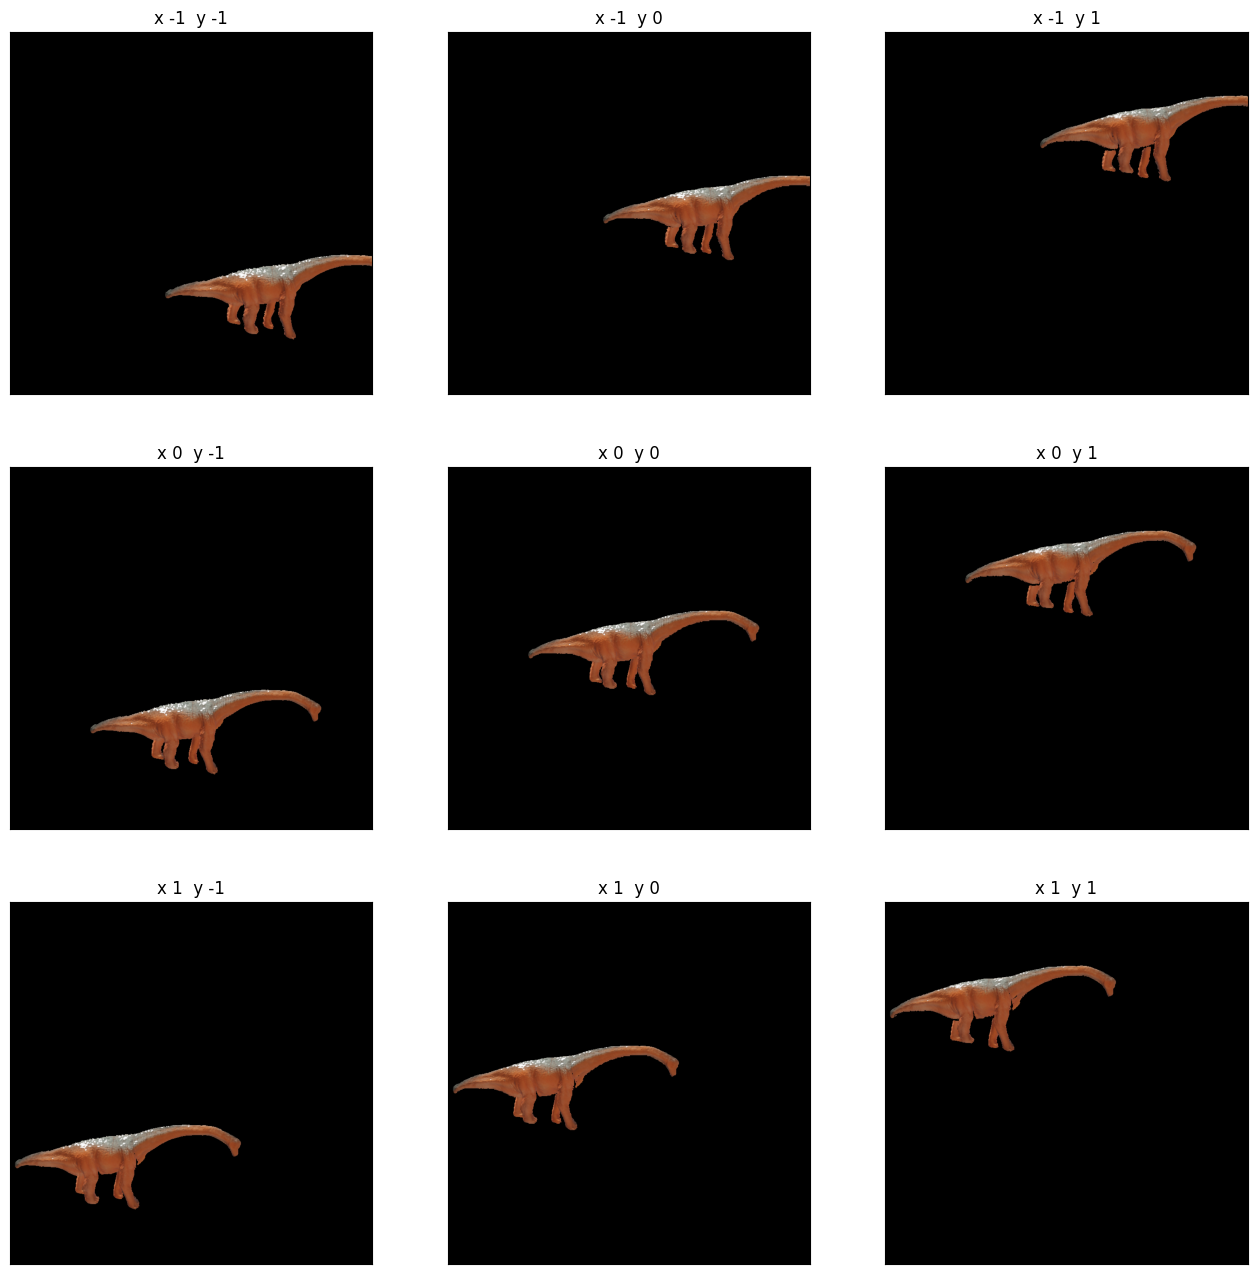

In [18]:
fig, axs = plt.subplots(3, 3, figsize=(16, 16))

axs = axs.flatten()
for i, (ax, img) in enumerate(zip(axs, translated_img)):
    ax.imshow(torch_to_pil(img))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"x {x_grid[i // x_grid.shape[0]]}  y {y_grid[i % y_grid.shape[0]]}")

In [21]:
# Zoom in and out

frame1_path = Path("/home/jh27kim/dataset/omniobject3d/OpenXD-OmniObject3D-New/raw/blender_renders/dinosaur/dinosaur_005/render/images/r_3.png")
depth1_path = Path("/home/jh27kim/dataset/omniobject3d/OpenXD-OmniObject3D-New/raw/blender_renders/dinosaur/dinosaur_005/render/depths/r_3_depth.exr")

z_grid = np.array([-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2.0])

transformation1 = torch.FloatTensor([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1],
]).unsqueeze(0)

zoomed_img = []
zoomed_depth = []

batch_size = 1
for dz in z_grid:
    print("dz", dz)
    transformation2 = torch.FloatTensor([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, dz],
        [0, 0, 0, 1],
    ]).unsqueeze(0)
    transformation2 = torch.linalg.inv(transformation2)

    frame1, warped_frame2, mask2, warped_depth2, flow12 = demo1(frame1_path, 
                                                                depth1_path,
                                                                transformation1, 
                                                                transformation2)
    zoomed_img.append(warped_frame2)
    zoomed_depth.append(warped_depth2)


dz -2.0
pos_vectors_homo torch.Size([1, 800, 800, 3, 1]) tensor([[400.],
        [400.],
        [  1.]], device='cuda:7') tensor([[450.],
        [450.],
        [  1.]], device='cuda:7') tensor([[400.],
        [450.],
        [  1.]], device='cuda:7')
unnormalized_pos torch.Size([1, 800, 800, 3, 1]) tensor([[0.],
        [0.],
        [1.]], device='cuda:7') tensor([[0.0722],
        [0.0722],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.0722],
        [1.0000]], device='cuda:7')
world_points center tensor([ 0.0450, -0.0436,  3.9582], device='cuda:7')
Max depth tensor(4.2188, device='cuda:7') Min depth tensor(3.8691, device='cuda:7')
world_points_homo torch.Size([1, 800, 800, 4, 1]) tensor([[0.0000],
        [0.0000],
        [3.8945],
        [1.0000]], device='cuda:7') tensor([[4.7273e+03],
        [4.7273e+03],
        [6.5504e+04],
        [1.0000e+00]], device='cuda:7') tensor([[0.0000],
        [0.3016],
        [4.1797],
        [1.0000]], device='cuda:7')

pos_vectors_homo torch.Size([1, 800, 800, 3, 1]) tensor([[400.],
        [400.],
        [  1.]], device='cuda:7') tensor([[450.],
        [450.],
        [  1.]], device='cuda:7') tensor([[400.],
        [450.],
        [  1.]], device='cuda:7')
unnormalized_pos torch.Size([1, 800, 800, 3, 1]) tensor([[0.],
        [0.],
        [1.]], device='cuda:7') tensor([[0.0722],
        [0.0722],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.0722],
        [1.0000]], device='cuda:7')
world_points center tensor([ 0.0450, -0.0436,  3.9582], device='cuda:7')
Max depth tensor(4.2188, device='cuda:7') Min depth tensor(3.8691, device='cuda:7')
world_points_homo torch.Size([1, 800, 800, 4, 1]) tensor([[0.0000],
        [0.0000],
        [3.8945],
        [1.0000]], device='cuda:7') tensor([[4.7273e+03],
        [4.7273e+03],
        [6.5504e+04],
        [1.0000e+00]], device='cuda:7') tensor([[0.0000],
        [0.3016],
        [4.1797],
        [1.0000]], device='cuda:7')
T2 T1.i

dz 2.0
pos_vectors_homo torch.Size([1, 800, 800, 3, 1]) tensor([[400.],
        [400.],
        [  1.]], device='cuda:7') tensor([[450.],
        [450.],
        [  1.]], device='cuda:7') tensor([[400.],
        [450.],
        [  1.]], device='cuda:7')
unnormalized_pos torch.Size([1, 800, 800, 3, 1]) tensor([[0.],
        [0.],
        [1.]], device='cuda:7') tensor([[0.0722],
        [0.0722],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.0722],
        [1.0000]], device='cuda:7')
world_points center tensor([ 0.0450, -0.0436,  3.9582], device='cuda:7')
Max depth tensor(4.2188, device='cuda:7') Min depth tensor(3.8691, device='cuda:7')
world_points_homo torch.Size([1, 800, 800, 4, 1]) tensor([[0.0000],
        [0.0000],
        [3.8945],
        [1.0000]], device='cuda:7') tensor([[4.7273e+03],
        [4.7273e+03],
        [6.5504e+04],
        [1.0000e+00]], device='cuda:7') tensor([[0.0000],
        [0.3016],
        [4.1797],
        [1.0000]], device='cuda:7')


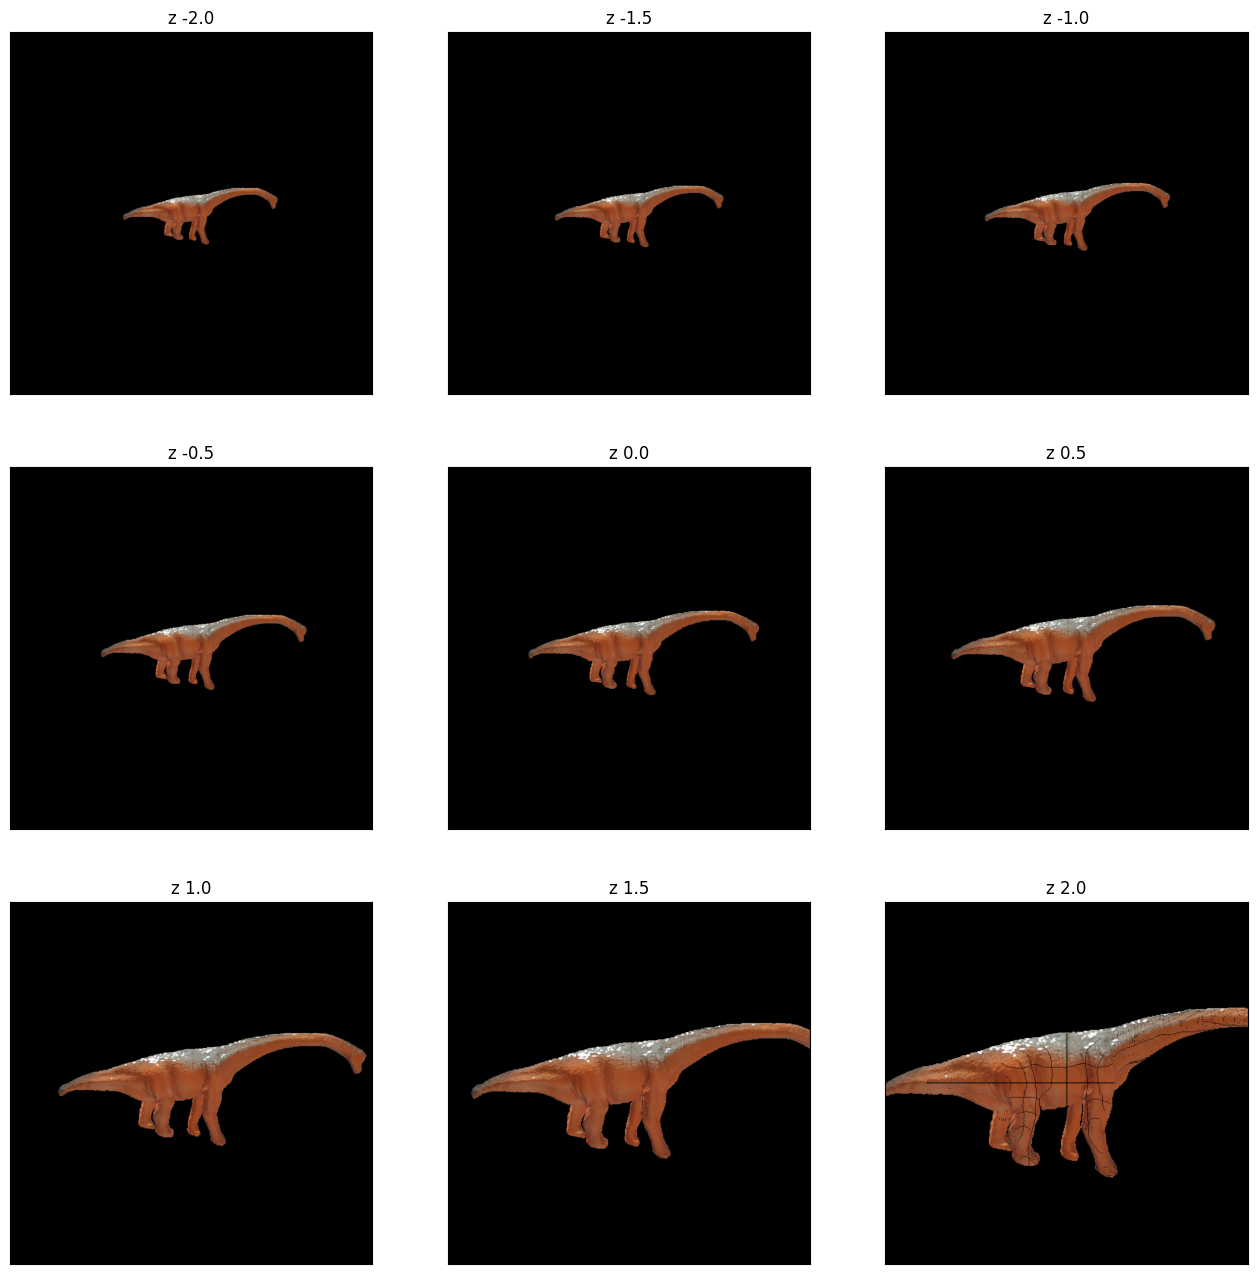

In [22]:
fig, axs = plt.subplots(3, 3, figsize=(16, 16))

axs = axs.flatten()
for i, (ax, img) in enumerate(zip(axs, zoomed_img)):
    ax.imshow(torch_to_pil(img))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"z {z_grid[i]}")

In [55]:
import imageio
import cv2
# Visualize 360 turn

# Zoom in and out

frame1_path = Path("/home/jh27kim/dataset/omniobject3d/OpenXD-OmniObject3D-New/raw/blender_renders/dinosaur/dinosaur_005/render/images/r_3.png")
depth1_path = Path("/home/jh27kim/dataset/omniobject3d/OpenXD-OmniObject3D-New/raw/blender_renders/dinosaur/dinosaur_005/render/depths/r_3_depth.exr")

phi_grid, theta_grid = np.linspace(0, 360, 100), np.array([90])

obj_center = torch.tensor([0.0450, -0.0436,  3.9582])

transformation1 = torch.FloatTensor([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1],
]).unsqueeze(0)

imgs = []

batch_size = 1
for phi_dl in phi_grid:
    for theta_dl in theta_grid:        
        transformation2 = rand_pose2(radius=torch.linalg.norm(obj_center).item(),
                                     theta=torch.FloatTensor([theta_dl]).to(device), 
                                     phi=torch.FloatTensor([phi_dl]).to(device),
                                     targets=obj_center)
        transformation2 = torch.linalg.inv(transformation2)
        
        frame1, warped_frame2, mask2, warped_depth2, flow12 = demo1(frame1_path, 
                                                                    depth1_path,
                                                                    transformation1, 
                                                                    transformation2)
        np_img = (warped_frame2.squeeze(0).permute(1, 2, 0).detach().cpu().numpy() * 255.0).astype(np.uint8)
#         np_img.save(f"/home/jh27kim/warp_latent/poc/experiment_warped_latent/{phi_dl}.png")
        imgs.append(np_img)
    
all_preds = np.stack(imgs, axis=0)

imageio.mimwrite(f"/home/jh27kim/warp_latent/poc/experiment_warped_latent/dinosaur_005_warped.gif", all_preds)

print("Saved video", all_preds.shape)

pos_vectors_homo torch.Size([1, 800, 800, 3, 1]) tensor([[400.],
        [400.],
        [  1.]], device='cuda:7') tensor([[450.],
        [450.],
        [  1.]], device='cuda:7') tensor([[400.],
        [450.],
        [  1.]], device='cuda:7')
unnormalized_pos torch.Size([1, 800, 800, 3, 1]) tensor([[0.],
        [0.],
        [1.]], device='cuda:7') tensor([[0.0722],
        [0.0722],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.0722],
        [1.0000]], device='cuda:7')
world_points center tensor([ 0.0450, -0.0436,  3.9582], device='cuda:7')
Max depth tensor(4.2188, device='cuda:7') Min depth tensor(3.8691, device='cuda:7')
world_points_homo torch.Size([1, 800, 800, 4, 1]) tensor([[0.0000],
        [0.0000],
        [3.8945],
        [1.0000]], device='cuda:7') tensor([[4.7273e+03],
        [4.7273e+03],
        [6.5504e+04],
        [1.0000e+00]], device='cuda:7') tensor([[0.0000],
        [0.3016],
        [4.1797],
        [1.0000]], device='cuda:7')
T2 T1.i

pos_vectors_homo torch.Size([1, 800, 800, 3, 1]) tensor([[400.],
        [400.],
        [  1.]], device='cuda:7') tensor([[450.],
        [450.],
        [  1.]], device='cuda:7') tensor([[400.],
        [450.],
        [  1.]], device='cuda:7')
unnormalized_pos torch.Size([1, 800, 800, 3, 1]) tensor([[0.],
        [0.],
        [1.]], device='cuda:7') tensor([[0.0722],
        [0.0722],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.0722],
        [1.0000]], device='cuda:7')
world_points center tensor([ 0.0450, -0.0436,  3.9582], device='cuda:7')
Max depth tensor(4.2188, device='cuda:7') Min depth tensor(3.8691, device='cuda:7')
world_points_homo torch.Size([1, 800, 800, 4, 1]) tensor([[0.0000],
        [0.0000],
        [3.8945],
        [1.0000]], device='cuda:7') tensor([[4.7273e+03],
        [4.7273e+03],
        [6.5504e+04],
        [1.0000e+00]], device='cuda:7') tensor([[0.0000],
        [0.3016],
        [4.1797],
        [1.0000]], device='cuda:7')
T2 T1.i

pos_vectors_homo torch.Size([1, 800, 800, 3, 1]) tensor([[400.],
        [400.],
        [  1.]], device='cuda:7') tensor([[450.],
        [450.],
        [  1.]], device='cuda:7') tensor([[400.],
        [450.],
        [  1.]], device='cuda:7')
unnormalized_pos torch.Size([1, 800, 800, 3, 1]) tensor([[0.],
        [0.],
        [1.]], device='cuda:7') tensor([[0.0722],
        [0.0722],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.0722],
        [1.0000]], device='cuda:7')
world_points center tensor([ 0.0450, -0.0436,  3.9582], device='cuda:7')
Max depth tensor(4.2188, device='cuda:7') Min depth tensor(3.8691, device='cuda:7')
world_points_homo torch.Size([1, 800, 800, 4, 1]) tensor([[0.0000],
        [0.0000],
        [3.8945],
        [1.0000]], device='cuda:7') tensor([[4.7273e+03],
        [4.7273e+03],
        [6.5504e+04],
        [1.0000e+00]], device='cuda:7') tensor([[0.0000],
        [0.3016],
        [4.1797],
        [1.0000]], device='cuda:7')
T2 T1.i

pos_vectors_homo torch.Size([1, 800, 800, 3, 1]) tensor([[400.],
        [400.],
        [  1.]], device='cuda:7') tensor([[450.],
        [450.],
        [  1.]], device='cuda:7') tensor([[400.],
        [450.],
        [  1.]], device='cuda:7')
unnormalized_pos torch.Size([1, 800, 800, 3, 1]) tensor([[0.],
        [0.],
        [1.]], device='cuda:7') tensor([[0.0722],
        [0.0722],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.0722],
        [1.0000]], device='cuda:7')
world_points center tensor([ 0.0450, -0.0436,  3.9582], device='cuda:7')
Max depth tensor(4.2188, device='cuda:7') Min depth tensor(3.8691, device='cuda:7')
world_points_homo torch.Size([1, 800, 800, 4, 1]) tensor([[0.0000],
        [0.0000],
        [3.8945],
        [1.0000]], device='cuda:7') tensor([[4.7273e+03],
        [4.7273e+03],
        [6.5504e+04],
        [1.0000e+00]], device='cuda:7') tensor([[0.0000],
        [0.3016],
        [4.1797],
        [1.0000]], device='cuda:7')
T2 T1.i

pos_vectors_homo torch.Size([1, 800, 800, 3, 1]) tensor([[400.],
        [400.],
        [  1.]], device='cuda:7') tensor([[450.],
        [450.],
        [  1.]], device='cuda:7') tensor([[400.],
        [450.],
        [  1.]], device='cuda:7')
unnormalized_pos torch.Size([1, 800, 800, 3, 1]) tensor([[0.],
        [0.],
        [1.]], device='cuda:7') tensor([[0.0722],
        [0.0722],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.0722],
        [1.0000]], device='cuda:7')
world_points center tensor([ 0.0450, -0.0436,  3.9582], device='cuda:7')
Max depth tensor(4.2188, device='cuda:7') Min depth tensor(3.8691, device='cuda:7')
world_points_homo torch.Size([1, 800, 800, 4, 1]) tensor([[0.0000],
        [0.0000],
        [3.8945],
        [1.0000]], device='cuda:7') tensor([[4.7273e+03],
        [4.7273e+03],
        [6.5504e+04],
        [1.0000e+00]], device='cuda:7') tensor([[0.0000],
        [0.3016],
        [4.1797],
        [1.0000]], device='cuda:7')
T2 T1.i

pos_vectors_homo torch.Size([1, 800, 800, 3, 1]) tensor([[400.],
        [400.],
        [  1.]], device='cuda:7') tensor([[450.],
        [450.],
        [  1.]], device='cuda:7') tensor([[400.],
        [450.],
        [  1.]], device='cuda:7')
unnormalized_pos torch.Size([1, 800, 800, 3, 1]) tensor([[0.],
        [0.],
        [1.]], device='cuda:7') tensor([[0.0722],
        [0.0722],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.0722],
        [1.0000]], device='cuda:7')
world_points center tensor([ 0.0450, -0.0436,  3.9582], device='cuda:7')
Max depth tensor(4.2188, device='cuda:7') Min depth tensor(3.8691, device='cuda:7')
world_points_homo torch.Size([1, 800, 800, 4, 1]) tensor([[0.0000],
        [0.0000],
        [3.8945],
        [1.0000]], device='cuda:7') tensor([[4.7273e+03],
        [4.7273e+03],
        [6.5504e+04],
        [1.0000e+00]], device='cuda:7') tensor([[0.0000],
        [0.3016],
        [4.1797],
        [1.0000]], device='cuda:7')
T2 T1.i

pos_vectors_homo torch.Size([1, 800, 800, 3, 1]) tensor([[400.],
        [400.],
        [  1.]], device='cuda:7') tensor([[450.],
        [450.],
        [  1.]], device='cuda:7') tensor([[400.],
        [450.],
        [  1.]], device='cuda:7')
unnormalized_pos torch.Size([1, 800, 800, 3, 1]) tensor([[0.],
        [0.],
        [1.]], device='cuda:7') tensor([[0.0722],
        [0.0722],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.0722],
        [1.0000]], device='cuda:7')
world_points center tensor([ 0.0450, -0.0436,  3.9582], device='cuda:7')
Max depth tensor(4.2188, device='cuda:7') Min depth tensor(3.8691, device='cuda:7')
world_points_homo torch.Size([1, 800, 800, 4, 1]) tensor([[0.0000],
        [0.0000],
        [3.8945],
        [1.0000]], device='cuda:7') tensor([[4.7273e+03],
        [4.7273e+03],
        [6.5504e+04],
        [1.0000e+00]], device='cuda:7') tensor([[0.0000],
        [0.3016],
        [4.1797],
        [1.0000]], device='cuda:7')
T2 T1.i

pos_vectors_homo torch.Size([1, 800, 800, 3, 1]) tensor([[400.],
        [400.],
        [  1.]], device='cuda:7') tensor([[450.],
        [450.],
        [  1.]], device='cuda:7') tensor([[400.],
        [450.],
        [  1.]], device='cuda:7')
unnormalized_pos torch.Size([1, 800, 800, 3, 1]) tensor([[0.],
        [0.],
        [1.]], device='cuda:7') tensor([[0.0722],
        [0.0722],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.0722],
        [1.0000]], device='cuda:7')
world_points center tensor([ 0.0450, -0.0436,  3.9582], device='cuda:7')
Max depth tensor(4.2188, device='cuda:7') Min depth tensor(3.8691, device='cuda:7')
world_points_homo torch.Size([1, 800, 800, 4, 1]) tensor([[0.0000],
        [0.0000],
        [3.8945],
        [1.0000]], device='cuda:7') tensor([[4.7273e+03],
        [4.7273e+03],
        [6.5504e+04],
        [1.0000e+00]], device='cuda:7') tensor([[0.0000],
        [0.3016],
        [4.1797],
        [1.0000]], device='cuda:7')
T2 T1.i

pos_vectors_homo torch.Size([1, 800, 800, 3, 1]) tensor([[400.],
        [400.],
        [  1.]], device='cuda:7') tensor([[450.],
        [450.],
        [  1.]], device='cuda:7') tensor([[400.],
        [450.],
        [  1.]], device='cuda:7')
unnormalized_pos torch.Size([1, 800, 800, 3, 1]) tensor([[0.],
        [0.],
        [1.]], device='cuda:7') tensor([[0.0722],
        [0.0722],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.0722],
        [1.0000]], device='cuda:7')
world_points center tensor([ 0.0450, -0.0436,  3.9582], device='cuda:7')
Max depth tensor(4.2188, device='cuda:7') Min depth tensor(3.8691, device='cuda:7')
world_points_homo torch.Size([1, 800, 800, 4, 1]) tensor([[0.0000],
        [0.0000],
        [3.8945],
        [1.0000]], device='cuda:7') tensor([[4.7273e+03],
        [4.7273e+03],
        [6.5504e+04],
        [1.0000e+00]], device='cuda:7') tensor([[0.0000],
        [0.3016],
        [4.1797],
        [1.0000]], device='cuda:7')
T2 T1.i

pos_vectors_homo torch.Size([1, 800, 800, 3, 1]) tensor([[400.],
        [400.],
        [  1.]], device='cuda:7') tensor([[450.],
        [450.],
        [  1.]], device='cuda:7') tensor([[400.],
        [450.],
        [  1.]], device='cuda:7')
unnormalized_pos torch.Size([1, 800, 800, 3, 1]) tensor([[0.],
        [0.],
        [1.]], device='cuda:7') tensor([[0.0722],
        [0.0722],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.0722],
        [1.0000]], device='cuda:7')
world_points center tensor([ 0.0450, -0.0436,  3.9582], device='cuda:7')
Max depth tensor(4.2188, device='cuda:7') Min depth tensor(3.8691, device='cuda:7')
world_points_homo torch.Size([1, 800, 800, 4, 1]) tensor([[0.0000],
        [0.0000],
        [3.8945],
        [1.0000]], device='cuda:7') tensor([[4.7273e+03],
        [4.7273e+03],
        [6.5504e+04],
        [1.0000e+00]], device='cuda:7') tensor([[0.0000],
        [0.3016],
        [4.1797],
        [1.0000]], device='cuda:7')
T2 T1.i

pos_vectors_homo torch.Size([1, 800, 800, 3, 1]) tensor([[400.],
        [400.],
        [  1.]], device='cuda:7') tensor([[450.],
        [450.],
        [  1.]], device='cuda:7') tensor([[400.],
        [450.],
        [  1.]], device='cuda:7')
unnormalized_pos torch.Size([1, 800, 800, 3, 1]) tensor([[0.],
        [0.],
        [1.]], device='cuda:7') tensor([[0.0722],
        [0.0722],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.0722],
        [1.0000]], device='cuda:7')
world_points center tensor([ 0.0450, -0.0436,  3.9582], device='cuda:7')
Max depth tensor(4.2188, device='cuda:7') Min depth tensor(3.8691, device='cuda:7')
world_points_homo torch.Size([1, 800, 800, 4, 1]) tensor([[0.0000],
        [0.0000],
        [3.8945],
        [1.0000]], device='cuda:7') tensor([[4.7273e+03],
        [4.7273e+03],
        [6.5504e+04],
        [1.0000e+00]], device='cuda:7') tensor([[0.0000],
        [0.3016],
        [4.1797],
        [1.0000]], device='cuda:7')
T2 T1.i

pos_vectors_homo torch.Size([1, 800, 800, 3, 1]) tensor([[400.],
        [400.],
        [  1.]], device='cuda:7') tensor([[450.],
        [450.],
        [  1.]], device='cuda:7') tensor([[400.],
        [450.],
        [  1.]], device='cuda:7')
unnormalized_pos torch.Size([1, 800, 800, 3, 1]) tensor([[0.],
        [0.],
        [1.]], device='cuda:7') tensor([[0.0722],
        [0.0722],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.0722],
        [1.0000]], device='cuda:7')
world_points center tensor([ 0.0450, -0.0436,  3.9582], device='cuda:7')
Max depth tensor(4.2188, device='cuda:7') Min depth tensor(3.8691, device='cuda:7')
world_points_homo torch.Size([1, 800, 800, 4, 1]) tensor([[0.0000],
        [0.0000],
        [3.8945],
        [1.0000]], device='cuda:7') tensor([[4.7273e+03],
        [4.7273e+03],
        [6.5504e+04],
        [1.0000e+00]], device='cuda:7') tensor([[0.0000],
        [0.3016],
        [4.1797],
        [1.0000]], device='cuda:7')
T2 T1.i

        [1.0000e+00]], device='cuda:7') tensor([[0.0000],
        [0.3016],
        [4.1797],
        [1.0000]], device='cuda:7')
T2 T1.inv tensor([[-9.9951e-01,  1.1113e-16,  3.1738e-02, -8.0627e-02],
        [ 1.3733e-09,  1.0000e+00,  4.3277e-08,  4.3610e-02],
        [-3.1738e-02,  4.3277e-08, -9.9951e-01,  7.9180e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]], device='cuda:7')
trans_world_homo tensor([[0.0430],
        [0.0436],
        [4.0253],
        [1.0000]], device='cuda:7') tensor([[-2.6461e+03],
        [ 4.7274e+03],
        [-6.5614e+04],
        [ 1.0000e+00]], device='cuda:7') tensor([[0.0520],
        [0.3453],
        [3.7403],
        [1.0000]], device='cuda:7')
trans_norm_points tensor([[1639.9119],
        [1640.3494],
        [   4.0253]], device='cuda:7') tensor([[-28078952.0000],
        [-22970422.0000],
        [   -65614.1406]], device='cuda:7') tensor([[1532.1754],
        [1735.3271],
        [   3.7403]], device='cuda:7')
uv space - 

pos_vectors_homo torch.Size([1, 800, 800, 3, 1]) tensor([[400.],
        [400.],
        [  1.]], device='cuda:7') tensor([[450.],
        [450.],
        [  1.]], device='cuda:7') tensor([[400.],
        [450.],
        [  1.]], device='cuda:7')
unnormalized_pos torch.Size([1, 800, 800, 3, 1]) tensor([[0.],
        [0.],
        [1.]], device='cuda:7') tensor([[0.0722],
        [0.0722],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.0722],
        [1.0000]], device='cuda:7')
world_points center tensor([ 0.0450, -0.0436,  3.9582], device='cuda:7')
Max depth tensor(4.2188, device='cuda:7') Min depth tensor(3.8691, device='cuda:7')
world_points_homo torch.Size([1, 800, 800, 4, 1]) tensor([[0.0000],
        [0.0000],
        [3.8945],
        [1.0000]], device='cuda:7') tensor([[4.7273e+03],
        [4.7273e+03],
        [6.5504e+04],
        [1.0000e+00]], device='cuda:7') tensor([[0.0000],
        [0.3016],
        [4.1797],
        [1.0000]], device='cuda:7')
T2 T1.i

pos_vectors_homo torch.Size([1, 800, 800, 3, 1]) tensor([[400.],
        [400.],
        [  1.]], device='cuda:7') tensor([[450.],
        [450.],
        [  1.]], device='cuda:7') tensor([[400.],
        [450.],
        [  1.]], device='cuda:7')
unnormalized_pos torch.Size([1, 800, 800, 3, 1]) tensor([[0.],
        [0.],
        [1.]], device='cuda:7') tensor([[0.0722],
        [0.0722],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.0722],
        [1.0000]], device='cuda:7')
world_points center tensor([ 0.0450, -0.0436,  3.9582], device='cuda:7')
Max depth tensor(4.2188, device='cuda:7') Min depth tensor(3.8691, device='cuda:7')
world_points_homo torch.Size([1, 800, 800, 4, 1]) tensor([[0.0000],
        [0.0000],
        [3.8945],
        [1.0000]], device='cuda:7') tensor([[4.7273e+03],
        [4.7273e+03],
        [6.5504e+04],
        [1.0000e+00]], device='cuda:7') tensor([[0.0000],
        [0.3016],
        [4.1797],
        [1.0000]], device='cuda:7')
T2 T1.i

pos_vectors_homo torch.Size([1, 800, 800, 3, 1]) tensor([[400.],
        [400.],
        [  1.]], device='cuda:7') tensor([[450.],
        [450.],
        [  1.]], device='cuda:7') tensor([[400.],
        [450.],
        [  1.]], device='cuda:7')
unnormalized_pos torch.Size([1, 800, 800, 3, 1]) tensor([[0.],
        [0.],
        [1.]], device='cuda:7') tensor([[0.0722],
        [0.0722],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.0722],
        [1.0000]], device='cuda:7')
world_points center tensor([ 0.0450, -0.0436,  3.9582], device='cuda:7')
Max depth tensor(4.2188, device='cuda:7') Min depth tensor(3.8691, device='cuda:7')
world_points_homo torch.Size([1, 800, 800, 4, 1]) tensor([[0.0000],
        [0.0000],
        [3.8945],
        [1.0000]], device='cuda:7') tensor([[4.7273e+03],
        [4.7273e+03],
        [6.5504e+04],
        [1.0000e+00]], device='cuda:7') tensor([[0.0000],
        [0.3016],
        [4.1797],
        [1.0000]], device='cuda:7')
T2 T1.i

pos_vectors_homo torch.Size([1, 800, 800, 3, 1]) tensor([[400.],
        [400.],
        [  1.]], device='cuda:7') tensor([[450.],
        [450.],
        [  1.]], device='cuda:7') tensor([[400.],
        [450.],
        [  1.]], device='cuda:7')
unnormalized_pos torch.Size([1, 800, 800, 3, 1]) tensor([[0.],
        [0.],
        [1.]], device='cuda:7') tensor([[0.0722],
        [0.0722],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.0722],
        [1.0000]], device='cuda:7')
world_points center tensor([ 0.0450, -0.0436,  3.9582], device='cuda:7')
Max depth tensor(4.2188, device='cuda:7') Min depth tensor(3.8691, device='cuda:7')
world_points_homo torch.Size([1, 800, 800, 4, 1]) tensor([[0.0000],
        [0.0000],
        [3.8945],
        [1.0000]], device='cuda:7') tensor([[4.7273e+03],
        [4.7273e+03],
        [6.5504e+04],
        [1.0000e+00]], device='cuda:7') tensor([[0.0000],
        [0.3016],
        [4.1797],
        [1.0000]], device='cuda:7')
T2 T1.i

pos_vectors_homo torch.Size([1, 800, 800, 3, 1]) tensor([[400.],
        [400.],
        [  1.]], device='cuda:7') tensor([[450.],
        [450.],
        [  1.]], device='cuda:7') tensor([[400.],
        [450.],
        [  1.]], device='cuda:7')
unnormalized_pos torch.Size([1, 800, 800, 3, 1]) tensor([[0.],
        [0.],
        [1.]], device='cuda:7') tensor([[0.0722],
        [0.0722],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.0722],
        [1.0000]], device='cuda:7')
world_points center tensor([ 0.0450, -0.0436,  3.9582], device='cuda:7')
Max depth tensor(4.2188, device='cuda:7') Min depth tensor(3.8691, device='cuda:7')
world_points_homo torch.Size([1, 800, 800, 4, 1]) tensor([[0.0000],
        [0.0000],
        [3.8945],
        [1.0000]], device='cuda:7') tensor([[4.7273e+03],
        [4.7273e+03],
        [6.5504e+04],
        [1.0000e+00]], device='cuda:7') tensor([[0.0000],
        [0.3016],
        [4.1797],
        [1.0000]], device='cuda:7')
T2 T1.i

pos_vectors_homo torch.Size([1, 800, 800, 3, 1]) tensor([[400.],
        [400.],
        [  1.]], device='cuda:7') tensor([[450.],
        [450.],
        [  1.]], device='cuda:7') tensor([[400.],
        [450.],
        [  1.]], device='cuda:7')
unnormalized_pos torch.Size([1, 800, 800, 3, 1]) tensor([[0.],
        [0.],
        [1.]], device='cuda:7') tensor([[0.0722],
        [0.0722],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.0722],
        [1.0000]], device='cuda:7')
world_points center tensor([ 0.0450, -0.0436,  3.9582], device='cuda:7')
Max depth tensor(4.2188, device='cuda:7') Min depth tensor(3.8691, device='cuda:7')
world_points_homo torch.Size([1, 800, 800, 4, 1]) tensor([[0.0000],
        [0.0000],
        [3.8945],
        [1.0000]], device='cuda:7') tensor([[4.7273e+03],
        [4.7273e+03],
        [6.5504e+04],
        [1.0000e+00]], device='cuda:7') tensor([[0.0000],
        [0.3016],
        [4.1797],
        [1.0000]], device='cuda:7')
T2 T1.i

pos_vectors_homo torch.Size([1, 800, 800, 3, 1]) tensor([[400.],
        [400.],
        [  1.]], device='cuda:7') tensor([[450.],
        [450.],
        [  1.]], device='cuda:7') tensor([[400.],
        [450.],
        [  1.]], device='cuda:7')
unnormalized_pos torch.Size([1, 800, 800, 3, 1]) tensor([[0.],
        [0.],
        [1.]], device='cuda:7') tensor([[0.0722],
        [0.0722],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.0722],
        [1.0000]], device='cuda:7')
world_points center tensor([ 0.0450, -0.0436,  3.9582], device='cuda:7')
Max depth tensor(4.2188, device='cuda:7') Min depth tensor(3.8691, device='cuda:7')
world_points_homo torch.Size([1, 800, 800, 4, 1]) tensor([[0.0000],
        [0.0000],
        [3.8945],
        [1.0000]], device='cuda:7') tensor([[4.7273e+03],
        [4.7273e+03],
        [6.5504e+04],
        [1.0000e+00]], device='cuda:7') tensor([[0.0000],
        [0.3016],
        [4.1797],
        [1.0000]], device='cuda:7')
T2 T1.i

pos_vectors_homo torch.Size([1, 800, 800, 3, 1]) tensor([[400.],
        [400.],
        [  1.]], device='cuda:7') tensor([[450.],
        [450.],
        [  1.]], device='cuda:7') tensor([[400.],
        [450.],
        [  1.]], device='cuda:7')
unnormalized_pos torch.Size([1, 800, 800, 3, 1]) tensor([[0.],
        [0.],
        [1.]], device='cuda:7') tensor([[0.0722],
        [0.0722],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.0722],
        [1.0000]], device='cuda:7')
world_points center tensor([ 0.0450, -0.0436,  3.9582], device='cuda:7')
Max depth tensor(4.2188, device='cuda:7') Min depth tensor(3.8691, device='cuda:7')
world_points_homo torch.Size([1, 800, 800, 4, 1]) tensor([[0.0000],
        [0.0000],
        [3.8945],
        [1.0000]], device='cuda:7') tensor([[4.7273e+03],
        [4.7273e+03],
        [6.5504e+04],
        [1.0000e+00]], device='cuda:7') tensor([[0.0000],
        [0.3016],
        [4.1797],
        [1.0000]], device='cuda:7')
T2 T1.i

pos_vectors_homo torch.Size([1, 800, 800, 3, 1]) tensor([[400.],
        [400.],
        [  1.]], device='cuda:7') tensor([[450.],
        [450.],
        [  1.]], device='cuda:7') tensor([[400.],
        [450.],
        [  1.]], device='cuda:7')
unnormalized_pos torch.Size([1, 800, 800, 3, 1]) tensor([[0.],
        [0.],
        [1.]], device='cuda:7') tensor([[0.0722],
        [0.0722],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.0722],
        [1.0000]], device='cuda:7')
world_points center tensor([ 0.0450, -0.0436,  3.9582], device='cuda:7')
Max depth tensor(4.2188, device='cuda:7') Min depth tensor(3.8691, device='cuda:7')
world_points_homo torch.Size([1, 800, 800, 4, 1]) tensor([[0.0000],
        [0.0000],
        [3.8945],
        [1.0000]], device='cuda:7') tensor([[4.7273e+03],
        [4.7273e+03],
        [6.5504e+04],
        [1.0000e+00]], device='cuda:7') tensor([[0.0000],
        [0.3016],
        [4.1797],
        [1.0000]], device='cuda:7')
T2 T1.i

pos_vectors_homo torch.Size([1, 800, 800, 3, 1]) tensor([[400.],
        [400.],
        [  1.]], device='cuda:7') tensor([[450.],
        [450.],
        [  1.]], device='cuda:7') tensor([[400.],
        [450.],
        [  1.]], device='cuda:7')
unnormalized_pos torch.Size([1, 800, 800, 3, 1]) tensor([[0.],
        [0.],
        [1.]], device='cuda:7') tensor([[0.0722],
        [0.0722],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.0722],
        [1.0000]], device='cuda:7')
world_points center tensor([ 0.0450, -0.0436,  3.9582], device='cuda:7')
Max depth tensor(4.2188, device='cuda:7') Min depth tensor(3.8691, device='cuda:7')
world_points_homo torch.Size([1, 800, 800, 4, 1]) tensor([[0.0000],
        [0.0000],
        [3.8945],
        [1.0000]], device='cuda:7') tensor([[4.7273e+03],
        [4.7273e+03],
        [6.5504e+04],
        [1.0000e+00]], device='cuda:7') tensor([[0.0000],
        [0.3016],
        [4.1797],
        [1.0000]], device='cuda:7')
T2 T1.i

pos_vectors_homo torch.Size([1, 800, 800, 3, 1]) tensor([[400.],
        [400.],
        [  1.]], device='cuda:7') tensor([[450.],
        [450.],
        [  1.]], device='cuda:7') tensor([[400.],
        [450.],
        [  1.]], device='cuda:7')
unnormalized_pos torch.Size([1, 800, 800, 3, 1]) tensor([[0.],
        [0.],
        [1.]], device='cuda:7') tensor([[0.0722],
        [0.0722],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.0722],
        [1.0000]], device='cuda:7')
world_points center tensor([ 0.0450, -0.0436,  3.9582], device='cuda:7')
Max depth tensor(4.2188, device='cuda:7') Min depth tensor(3.8691, device='cuda:7')
world_points_homo torch.Size([1, 800, 800, 4, 1]) tensor([[0.0000],
        [0.0000],
        [3.8945],
        [1.0000]], device='cuda:7') tensor([[4.7273e+03],
        [4.7273e+03],
        [6.5504e+04],
        [1.0000e+00]], device='cuda:7') tensor([[0.0000],
        [0.3016],
        [4.1797],
        [1.0000]], device='cuda:7')
T2 T1.i

pos_vectors_homo torch.Size([1, 800, 800, 3, 1]) tensor([[400.],
        [400.],
        [  1.]], device='cuda:7') tensor([[450.],
        [450.],
        [  1.]], device='cuda:7') tensor([[400.],
        [450.],
        [  1.]], device='cuda:7')
unnormalized_pos torch.Size([1, 800, 800, 3, 1]) tensor([[0.],
        [0.],
        [1.]], device='cuda:7') tensor([[0.0722],
        [0.0722],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.0722],
        [1.0000]], device='cuda:7')
world_points center tensor([ 0.0450, -0.0436,  3.9582], device='cuda:7')
Max depth tensor(4.2188, device='cuda:7') Min depth tensor(3.8691, device='cuda:7')
world_points_homo torch.Size([1, 800, 800, 4, 1]) tensor([[0.0000],
        [0.0000],
        [3.8945],
        [1.0000]], device='cuda:7') tensor([[4.7273e+03],
        [4.7273e+03],
        [6.5504e+04],
        [1.0000e+00]], device='cuda:7') tensor([[0.0000],
        [0.3016],
        [4.1797],
        [1.0000]], device='cuda:7')
T2 T1.i

In [56]:
import imageio
import cv2
# Visualize 360 turn

# Zoom in and out

frame1_path = Path("/home/jh27kim/dataset/omniobject3d/OpenXD-OmniObject3D-New/raw/blender_renders/antique/antique_004/render/images/r_55.png")
depth1_path = Path("/home/jh27kim/dataset/omniobject3d/OpenXD-OmniObject3D-New/raw/blender_renders/antique/antique_004/render/depths/r_55_depth.exr")

phi_grid, theta_grid = np.linspace(0, 360, 100), np.array([90])

obj_center = torch.tensor([0.0321, -0.0071,  3.7291])

transformation1 = torch.FloatTensor([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1],
]).unsqueeze(0)

imgs = []

batch_size = 1
for phi_dl in phi_grid:
    for theta_dl in theta_grid:        
        transformation2 = rand_pose2(radius=torch.linalg.norm(obj_center).item(),
                                     theta=torch.FloatTensor([theta_dl]).to(device), 
                                     phi=torch.FloatTensor([phi_dl]).to(device),
                                     targets=obj_center)
        transformation2 = torch.linalg.inv(transformation2)
        
        frame1, warped_frame2, mask2, warped_depth2, flow12 = demo1(frame1_path, 
                                                                    depth1_path,
                                                                    transformation1, 
                                                                    transformation2)
        np_img = (warped_frame2.squeeze(0).permute(1, 2, 0).detach().cpu().numpy() * 255.0).astype(np.uint8)
#         np_img.save(f"/home/jh27kim/warp_latent/poc/experiment_warped_latent/{phi_dl}.png")
        imgs.append(np_img)
    
all_preds = np.stack(imgs, axis=0)

imageio.mimwrite(f"/home/jh27kim/warp_latent/poc/experiment_warped_latent/antique_004_warped.gif", all_preds)

print("Saved video", all_preds.shape)

pos_vectors_homo torch.Size([1, 800, 800, 3, 1]) tensor([[400.],
        [400.],
        [  1.]], device='cuda:7') tensor([[450.],
        [450.],
        [  1.]], device='cuda:7') tensor([[400.],
        [450.],
        [  1.]], device='cuda:7')
unnormalized_pos torch.Size([1, 800, 800, 3, 1]) tensor([[0.],
        [0.],
        [1.]], device='cuda:7') tensor([[0.0722],
        [0.0722],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.0722],
        [1.0000]], device='cuda:7')
world_points center tensor([ 0.0321, -0.0071,  3.7291], device='cuda:7')
Max depth tensor(4.2578, device='cuda:7') Min depth tensor(3.4492, device='cuda:7')
world_points_homo torch.Size([1, 800, 800, 4, 1]) tensor([[0.0000],
        [0.0000],
        [3.6445],
        [1.0000]], device='cuda:7') tensor([[0.2647],
        [0.2647],
        [3.6680],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.2571],
        [3.5625],
        [1.0000]], device='cuda:7')
T2 T1.inv tensor([[ 1.0

pos_vectors_homo torch.Size([1, 800, 800, 3, 1]) tensor([[400.],
        [400.],
        [  1.]], device='cuda:7') tensor([[450.],
        [450.],
        [  1.]], device='cuda:7') tensor([[400.],
        [450.],
        [  1.]], device='cuda:7')
unnormalized_pos torch.Size([1, 800, 800, 3, 1]) tensor([[0.],
        [0.],
        [1.]], device='cuda:7') tensor([[0.0722],
        [0.0722],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.0722],
        [1.0000]], device='cuda:7')
world_points center tensor([ 0.0321, -0.0071,  3.7291], device='cuda:7')
Max depth tensor(4.2578, device='cuda:7') Min depth tensor(3.4492, device='cuda:7')
world_points_homo torch.Size([1, 800, 800, 4, 1]) tensor([[0.0000],
        [0.0000],
        [3.6445],
        [1.0000]], device='cuda:7') tensor([[0.2647],
        [0.2647],
        [3.6680],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.2571],
        [3.5625],
        [1.0000]], device='cuda:7')
T2 T1.inv tensor([[ 9.5

pos_vectors_homo torch.Size([1, 800, 800, 3, 1]) tensor([[400.],
        [400.],
        [  1.]], device='cuda:7') tensor([[450.],
        [450.],
        [  1.]], device='cuda:7') tensor([[400.],
        [450.],
        [  1.]], device='cuda:7')
unnormalized_pos torch.Size([1, 800, 800, 3, 1]) tensor([[0.],
        [0.],
        [1.]], device='cuda:7') tensor([[0.0722],
        [0.0722],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.0722],
        [1.0000]], device='cuda:7')
world_points center tensor([ 0.0321, -0.0071,  3.7291], device='cuda:7')
Max depth tensor(4.2578, device='cuda:7') Min depth tensor(3.4492, device='cuda:7')
world_points_homo torch.Size([1, 800, 800, 4, 1]) tensor([[0.0000],
        [0.0000],
        [3.6445],
        [1.0000]], device='cuda:7') tensor([[0.2647],
        [0.2647],
        [3.6680],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.2571],
        [3.5625],
        [1.0000]], device='cuda:7')
T2 T1.inv tensor([[ 8.4

pos_vectors_homo torch.Size([1, 800, 800, 3, 1]) tensor([[400.],
        [400.],
        [  1.]], device='cuda:7') tensor([[450.],
        [450.],
        [  1.]], device='cuda:7') tensor([[400.],
        [450.],
        [  1.]], device='cuda:7')
unnormalized_pos torch.Size([1, 800, 800, 3, 1]) tensor([[0.],
        [0.],
        [1.]], device='cuda:7') tensor([[0.0722],
        [0.0722],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.0722],
        [1.0000]], device='cuda:7')
world_points center tensor([ 0.0321, -0.0071,  3.7291], device='cuda:7')
Max depth tensor(4.2578, device='cuda:7') Min depth tensor(3.4492, device='cuda:7')
world_points_homo torch.Size([1, 800, 800, 4, 1]) tensor([[0.0000],
        [0.0000],
        [3.6445],
        [1.0000]], device='cuda:7') tensor([[0.2647],
        [0.2647],
        [3.6680],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.2571],
        [3.5625],
        [1.0000]], device='cuda:7')
T2 T1.inv tensor([[ 6.7

pos_vectors_homo torch.Size([1, 800, 800, 3, 1]) tensor([[400.],
        [400.],
        [  1.]], device='cuda:7') tensor([[450.],
        [450.],
        [  1.]], device='cuda:7') tensor([[400.],
        [450.],
        [  1.]], device='cuda:7')
unnormalized_pos torch.Size([1, 800, 800, 3, 1]) tensor([[0.],
        [0.],
        [1.]], device='cuda:7') tensor([[0.0722],
        [0.0722],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.0722],
        [1.0000]], device='cuda:7')
world_points center tensor([ 0.0321, -0.0071,  3.7291], device='cuda:7')
Max depth tensor(4.2578, device='cuda:7') Min depth tensor(3.4492, device='cuda:7')
world_points_homo torch.Size([1, 800, 800, 4, 1]) tensor([[0.0000],
        [0.0000],
        [3.6445],
        [1.0000]], device='cuda:7') tensor([[0.2647],
        [0.2647],
        [3.6680],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.2571],
        [3.5625],
        [1.0000]], device='cuda:7')
T2 T1.inv tensor([[ 4.7

pos_vectors_homo torch.Size([1, 800, 800, 3, 1]) tensor([[400.],
        [400.],
        [  1.]], device='cuda:7') tensor([[450.],
        [450.],
        [  1.]], device='cuda:7') tensor([[400.],
        [450.],
        [  1.]], device='cuda:7')
unnormalized_pos torch.Size([1, 800, 800, 3, 1]) tensor([[0.],
        [0.],
        [1.]], device='cuda:7') tensor([[0.0722],
        [0.0722],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.0722],
        [1.0000]], device='cuda:7')
world_points center tensor([ 0.0321, -0.0071,  3.7291], device='cuda:7')
Max depth tensor(4.2578, device='cuda:7') Min depth tensor(3.4492, device='cuda:7')
world_points_homo torch.Size([1, 800, 800, 4, 1]) tensor([[0.0000],
        [0.0000],
        [3.6445],
        [1.0000]], device='cuda:7') tensor([[0.2647],
        [0.2647],
        [3.6680],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.2571],
        [3.5625],
        [1.0000]], device='cuda:7')
T2 T1.inv tensor([[ 2.3

pos_vectors_homo torch.Size([1, 800, 800, 3, 1]) tensor([[400.],
        [400.],
        [  1.]], device='cuda:7') tensor([[450.],
        [450.],
        [  1.]], device='cuda:7') tensor([[400.],
        [450.],
        [  1.]], device='cuda:7')
unnormalized_pos torch.Size([1, 800, 800, 3, 1]) tensor([[0.],
        [0.],
        [1.]], device='cuda:7') tensor([[0.0722],
        [0.0722],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.0722],
        [1.0000]], device='cuda:7')
world_points center tensor([ 0.0321, -0.0071,  3.7291], device='cuda:7')
Max depth tensor(4.2578, device='cuda:7') Min depth tensor(3.4492, device='cuda:7')
world_points_homo torch.Size([1, 800, 800, 4, 1]) tensor([[0.0000],
        [0.0000],
        [3.6445],
        [1.0000]], device='cuda:7') tensor([[0.2647],
        [0.2647],
        [3.6680],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.2571],
        [3.5625],
        [1.0000]], device='cuda:7')
T2 T1.inv tensor([[-1.5

pos_vectors_homo torch.Size([1, 800, 800, 3, 1]) tensor([[400.],
        [400.],
        [  1.]], device='cuda:7') tensor([[450.],
        [450.],
        [  1.]], device='cuda:7') tensor([[400.],
        [450.],
        [  1.]], device='cuda:7')
unnormalized_pos torch.Size([1, 800, 800, 3, 1]) tensor([[0.],
        [0.],
        [1.]], device='cuda:7') tensor([[0.0722],
        [0.0722],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.0722],
        [1.0000]], device='cuda:7')
world_points center tensor([ 0.0321, -0.0071,  3.7291], device='cuda:7')
Max depth tensor(4.2578, device='cuda:7') Min depth tensor(3.4492, device='cuda:7')
world_points_homo torch.Size([1, 800, 800, 4, 1]) tensor([[0.0000],
        [0.0000],
        [3.6445],
        [1.0000]], device='cuda:7') tensor([[0.2647],
        [0.2647],
        [3.6680],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.2571],
        [3.5625],
        [1.0000]], device='cuda:7')
T2 T1.inv tensor([[-2.6

pos_vectors_homo torch.Size([1, 800, 800, 3, 1]) tensor([[400.],
        [400.],
        [  1.]], device='cuda:7') tensor([[450.],
        [450.],
        [  1.]], device='cuda:7') tensor([[400.],
        [450.],
        [  1.]], device='cuda:7')
unnormalized_pos torch.Size([1, 800, 800, 3, 1]) tensor([[0.],
        [0.],
        [1.]], device='cuda:7') tensor([[0.0722],
        [0.0722],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.0722],
        [1.0000]], device='cuda:7')
world_points center tensor([ 0.0321, -0.0071,  3.7291], device='cuda:7')
Max depth tensor(4.2578, device='cuda:7') Min depth tensor(3.4492, device='cuda:7')
world_points_homo torch.Size([1, 800, 800, 4, 1]) tensor([[0.0000],
        [0.0000],
        [3.6445],
        [1.0000]], device='cuda:7') tensor([[0.2647],
        [0.2647],
        [3.6680],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.2571],
        [3.5625],
        [1.0000]], device='cuda:7')
T2 T1.inv tensor([[-5.0

pos_vectors_homo torch.Size([1, 800, 800, 3, 1]) tensor([[400.],
        [400.],
        [  1.]], device='cuda:7') tensor([[450.],
        [450.],
        [  1.]], device='cuda:7') tensor([[400.],
        [450.],
        [  1.]], device='cuda:7')
unnormalized_pos torch.Size([1, 800, 800, 3, 1]) tensor([[0.],
        [0.],
        [1.]], device='cuda:7') tensor([[0.0722],
        [0.0722],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.0722],
        [1.0000]], device='cuda:7')
world_points center tensor([ 0.0321, -0.0071,  3.7291], device='cuda:7')
Max depth tensor(4.2578, device='cuda:7') Min depth tensor(3.4492, device='cuda:7')
world_points_homo torch.Size([1, 800, 800, 4, 1]) tensor([[0.0000],
        [0.0000],
        [3.6445],
        [1.0000]], device='cuda:7') tensor([[0.2647],
        [0.2647],
        [3.6680],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.2571],
        [3.5625],
        [1.0000]], device='cuda:7')
T2 T1.inv tensor([[-7.0

pos_vectors_homo torch.Size([1, 800, 800, 3, 1]) tensor([[400.],
        [400.],
        [  1.]], device='cuda:7') tensor([[450.],
        [450.],
        [  1.]], device='cuda:7') tensor([[400.],
        [450.],
        [  1.]], device='cuda:7')
unnormalized_pos torch.Size([1, 800, 800, 3, 1]) tensor([[0.],
        [0.],
        [1.]], device='cuda:7') tensor([[0.0722],
        [0.0722],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.0722],
        [1.0000]], device='cuda:7')
world_points center tensor([ 0.0321, -0.0071,  3.7291], device='cuda:7')
Max depth tensor(4.2578, device='cuda:7') Min depth tensor(3.4492, device='cuda:7')
world_points_homo torch.Size([1, 800, 800, 4, 1]) tensor([[0.0000],
        [0.0000],
        [3.6445],
        [1.0000]], device='cuda:7') tensor([[0.2647],
        [0.2647],
        [3.6680],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.2571],
        [3.5625],
        [1.0000]], device='cuda:7')
T2 T1.inv tensor([[-8.5

pos_vectors_homo torch.Size([1, 800, 800, 3, 1]) tensor([[400.],
        [400.],
        [  1.]], device='cuda:7') tensor([[450.],
        [450.],
        [  1.]], device='cuda:7') tensor([[400.],
        [450.],
        [  1.]], device='cuda:7')
unnormalized_pos torch.Size([1, 800, 800, 3, 1]) tensor([[0.],
        [0.],
        [1.]], device='cuda:7') tensor([[0.0722],
        [0.0722],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.0722],
        [1.0000]], device='cuda:7')
world_points center tensor([ 0.0321, -0.0071,  3.7291], device='cuda:7')
Max depth tensor(4.2578, device='cuda:7') Min depth tensor(3.4492, device='cuda:7')
world_points_homo torch.Size([1, 800, 800, 4, 1]) tensor([[0.0000],
        [0.0000],
        [3.6445],
        [1.0000]], device='cuda:7') tensor([[0.2647],
        [0.2647],
        [3.6680],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.2571],
        [3.5625],
        [1.0000]], device='cuda:7')
T2 T1.inv tensor([[-9.5

pos_vectors_homo torch.Size([1, 800, 800, 3, 1]) tensor([[400.],
        [400.],
        [  1.]], device='cuda:7') tensor([[450.],
        [450.],
        [  1.]], device='cuda:7') tensor([[400.],
        [450.],
        [  1.]], device='cuda:7')
unnormalized_pos torch.Size([1, 800, 800, 3, 1]) tensor([[0.],
        [0.],
        [1.]], device='cuda:7') tensor([[0.0722],
        [0.0722],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.0722],
        [1.0000]], device='cuda:7')
world_points center tensor([ 0.0321, -0.0071,  3.7291], device='cuda:7')
Max depth tensor(4.2578, device='cuda:7') Min depth tensor(3.4492, device='cuda:7')
world_points_homo torch.Size([1, 800, 800, 4, 1]) tensor([[0.0000],
        [0.0000],
        [3.6445],
        [1.0000]], device='cuda:7') tensor([[0.2647],
        [0.2647],
        [3.6680],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.2571],
        [3.5625],
        [1.0000]], device='cuda:7')
T2 T1.inv tensor([[-9.9

pos_vectors_homo torch.Size([1, 800, 800, 3, 1]) tensor([[400.],
        [400.],
        [  1.]], device='cuda:7') tensor([[450.],
        [450.],
        [  1.]], device='cuda:7') tensor([[400.],
        [450.],
        [  1.]], device='cuda:7')
unnormalized_pos torch.Size([1, 800, 800, 3, 1]) tensor([[0.],
        [0.],
        [1.]], device='cuda:7') tensor([[0.0722],
        [0.0722],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.0722],
        [1.0000]], device='cuda:7')
world_points center tensor([ 0.0321, -0.0071,  3.7291], device='cuda:7')
Max depth tensor(4.2578, device='cuda:7') Min depth tensor(3.4492, device='cuda:7')
world_points_homo torch.Size([1, 800, 800, 4, 1]) tensor([[0.0000],
        [0.0000],
        [3.6445],
        [1.0000]], device='cuda:7') tensor([[0.2647],
        [0.2647],
        [3.6680],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.2571],
        [3.5625],
        [1.0000]], device='cuda:7')
T2 T1.inv tensor([[-9.7

pos_vectors_homo torch.Size([1, 800, 800, 3, 1]) tensor([[400.],
        [400.],
        [  1.]], device='cuda:7') tensor([[450.],
        [450.],
        [  1.]], device='cuda:7') tensor([[400.],
        [450.],
        [  1.]], device='cuda:7')
unnormalized_pos torch.Size([1, 800, 800, 3, 1]) tensor([[0.],
        [0.],
        [1.]], device='cuda:7') tensor([[0.0722],
        [0.0722],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.0722],
        [1.0000]], device='cuda:7')
world_points center tensor([ 0.0321, -0.0071,  3.7291], device='cuda:7')
Max depth tensor(4.2578, device='cuda:7') Min depth tensor(3.4492, device='cuda:7')
world_points_homo torch.Size([1, 800, 800, 4, 1]) tensor([[0.0000],
        [0.0000],
        [3.6445],
        [1.0000]], device='cuda:7') tensor([[0.2647],
        [0.2647],
        [3.6680],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.2571],
        [3.5625],
        [1.0000]], device='cuda:7')
T2 T1.inv tensor([[-8.8

pos_vectors_homo torch.Size([1, 800, 800, 3, 1]) tensor([[400.],
        [400.],
        [  1.]], device='cuda:7') tensor([[450.],
        [450.],
        [  1.]], device='cuda:7') tensor([[400.],
        [450.],
        [  1.]], device='cuda:7')
unnormalized_pos torch.Size([1, 800, 800, 3, 1]) tensor([[0.],
        [0.],
        [1.]], device='cuda:7') tensor([[0.0722],
        [0.0722],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.0722],
        [1.0000]], device='cuda:7')
world_points center tensor([ 0.0321, -0.0071,  3.7291], device='cuda:7')
Max depth tensor(4.2578, device='cuda:7') Min depth tensor(3.4492, device='cuda:7')
world_points_homo torch.Size([1, 800, 800, 4, 1]) tensor([[0.0000],
        [0.0000],
        [3.6445],
        [1.0000]], device='cuda:7') tensor([[0.2647],
        [0.2647],
        [3.6680],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.2571],
        [3.5625],
        [1.0000]], device='cuda:7')
T2 T1.inv tensor([[-7.4

pos_vectors_homo torch.Size([1, 800, 800, 3, 1]) tensor([[400.],
        [400.],
        [  1.]], device='cuda:7') tensor([[450.],
        [450.],
        [  1.]], device='cuda:7') tensor([[400.],
        [450.],
        [  1.]], device='cuda:7')
unnormalized_pos torch.Size([1, 800, 800, 3, 1]) tensor([[0.],
        [0.],
        [1.]], device='cuda:7') tensor([[0.0722],
        [0.0722],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.0722],
        [1.0000]], device='cuda:7')
world_points center tensor([ 0.0321, -0.0071,  3.7291], device='cuda:7')
Max depth tensor(4.2578, device='cuda:7') Min depth tensor(3.4492, device='cuda:7')
world_points_homo torch.Size([1, 800, 800, 4, 1]) tensor([[0.0000],
        [0.0000],
        [3.6445],
        [1.0000]], device='cuda:7') tensor([[0.2647],
        [0.2647],
        [3.6680],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.2571],
        [3.5625],
        [1.0000]], device='cuda:7')
T2 T1.inv tensor([[-5.5

pos_vectors_homo torch.Size([1, 800, 800, 3, 1]) tensor([[400.],
        [400.],
        [  1.]], device='cuda:7') tensor([[450.],
        [450.],
        [  1.]], device='cuda:7') tensor([[400.],
        [450.],
        [  1.]], device='cuda:7')
unnormalized_pos torch.Size([1, 800, 800, 3, 1]) tensor([[0.],
        [0.],
        [1.]], device='cuda:7') tensor([[0.0722],
        [0.0722],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.0722],
        [1.0000]], device='cuda:7')
world_points center tensor([ 0.0321, -0.0071,  3.7291], device='cuda:7')
Max depth tensor(4.2578, device='cuda:7') Min depth tensor(3.4492, device='cuda:7')
world_points_homo torch.Size([1, 800, 800, 4, 1]) tensor([[0.0000],
        [0.0000],
        [3.6445],
        [1.0000]], device='cuda:7') tensor([[0.2647],
        [0.2647],
        [3.6680],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.2571],
        [3.5625],
        [1.0000]], device='cuda:7')
T2 T1.inv tensor([[-3.2

pos_vectors_homo torch.Size([1, 800, 800, 3, 1]) tensor([[400.],
        [400.],
        [  1.]], device='cuda:7') tensor([[450.],
        [450.],
        [  1.]], device='cuda:7') tensor([[400.],
        [450.],
        [  1.]], device='cuda:7')
unnormalized_pos torch.Size([1, 800, 800, 3, 1]) tensor([[0.],
        [0.],
        [1.]], device='cuda:7') tensor([[0.0722],
        [0.0722],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.0722],
        [1.0000]], device='cuda:7')
world_points center tensor([ 0.0321, -0.0071,  3.7291], device='cuda:7')
Max depth tensor(4.2578, device='cuda:7') Min depth tensor(3.4492, device='cuda:7')
world_points_homo torch.Size([1, 800, 800, 4, 1]) tensor([[0.0000],
        [0.0000],
        [3.6445],
        [1.0000]], device='cuda:7') tensor([[0.2647],
        [0.2647],
        [3.6680],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.2571],
        [3.5625],
        [1.0000]], device='cuda:7')
T2 T1.inv tensor([[-7.9

pos_vectors_homo torch.Size([1, 800, 800, 3, 1]) tensor([[400.],
        [400.],
        [  1.]], device='cuda:7') tensor([[450.],
        [450.],
        [  1.]], device='cuda:7') tensor([[400.],
        [450.],
        [  1.]], device='cuda:7')
unnormalized_pos torch.Size([1, 800, 800, 3, 1]) tensor([[0.],
        [0.],
        [1.]], device='cuda:7') tensor([[0.0722],
        [0.0722],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.0722],
        [1.0000]], device='cuda:7')
world_points center tensor([ 0.0321, -0.0071,  3.7291], device='cuda:7')
Max depth tensor(4.2578, device='cuda:7') Min depth tensor(3.4492, device='cuda:7')
world_points_homo torch.Size([1, 800, 800, 4, 1]) tensor([[0.0000],
        [0.0000],
        [3.6445],
        [1.0000]], device='cuda:7') tensor([[0.2647],
        [0.2647],
        [3.6680],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.2571],
        [3.5625],
        [1.0000]], device='cuda:7')
T2 T1.inv tensor([[ 1.7

pos_vectors_homo torch.Size([1, 800, 800, 3, 1]) tensor([[400.],
        [400.],
        [  1.]], device='cuda:7') tensor([[450.],
        [450.],
        [  1.]], device='cuda:7') tensor([[400.],
        [450.],
        [  1.]], device='cuda:7')
unnormalized_pos torch.Size([1, 800, 800, 3, 1]) tensor([[0.],
        [0.],
        [1.]], device='cuda:7') tensor([[0.0722],
        [0.0722],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.0722],
        [1.0000]], device='cuda:7')
world_points center tensor([ 0.0321, -0.0071,  3.7291], device='cuda:7')
Max depth tensor(4.2578, device='cuda:7') Min depth tensor(3.4492, device='cuda:7')
world_points_homo torch.Size([1, 800, 800, 4, 1]) tensor([[0.0000],
        [0.0000],
        [3.6445],
        [1.0000]], device='cuda:7') tensor([[0.2647],
        [0.2647],
        [3.6680],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.2571],
        [3.5625],
        [1.0000]], device='cuda:7')
T2 T1.inv tensor([[ 4.1

pos_vectors_homo torch.Size([1, 800, 800, 3, 1]) tensor([[400.],
        [400.],
        [  1.]], device='cuda:7') tensor([[450.],
        [450.],
        [  1.]], device='cuda:7') tensor([[400.],
        [450.],
        [  1.]], device='cuda:7')
unnormalized_pos torch.Size([1, 800, 800, 3, 1]) tensor([[0.],
        [0.],
        [1.]], device='cuda:7') tensor([[0.0722],
        [0.0722],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.0722],
        [1.0000]], device='cuda:7')
world_points center tensor([ 0.0321, -0.0071,  3.7291], device='cuda:7')
Max depth tensor(4.2578, device='cuda:7') Min depth tensor(3.4492, device='cuda:7')
world_points_homo torch.Size([1, 800, 800, 4, 1]) tensor([[0.0000],
        [0.0000],
        [3.6445],
        [1.0000]], device='cuda:7') tensor([[0.2647],
        [0.2647],
        [3.6680],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.2571],
        [3.5625],
        [1.0000]], device='cuda:7')
T2 T1.inv tensor([[ 6.3

pos_vectors_homo torch.Size([1, 800, 800, 3, 1]) tensor([[400.],
        [400.],
        [  1.]], device='cuda:7') tensor([[450.],
        [450.],
        [  1.]], device='cuda:7') tensor([[400.],
        [450.],
        [  1.]], device='cuda:7')
unnormalized_pos torch.Size([1, 800, 800, 3, 1]) tensor([[0.],
        [0.],
        [1.]], device='cuda:7') tensor([[0.0722],
        [0.0722],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.0722],
        [1.0000]], device='cuda:7')
world_points center tensor([ 0.0321, -0.0071,  3.7291], device='cuda:7')
Max depth tensor(4.2578, device='cuda:7') Min depth tensor(3.4492, device='cuda:7')
world_points_homo torch.Size([1, 800, 800, 4, 1]) tensor([[0.0000],
        [0.0000],
        [3.6445],
        [1.0000]], device='cuda:7') tensor([[0.2647],
        [0.2647],
        [3.6680],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.2571],
        [3.5625],
        [1.0000]], device='cuda:7')
T2 T1.inv tensor([[ 8.0

pos_vectors_homo torch.Size([1, 800, 800, 3, 1]) tensor([[400.],
        [400.],
        [  1.]], device='cuda:7') tensor([[450.],
        [450.],
        [  1.]], device='cuda:7') tensor([[400.],
        [450.],
        [  1.]], device='cuda:7')
unnormalized_pos torch.Size([1, 800, 800, 3, 1]) tensor([[0.],
        [0.],
        [1.]], device='cuda:7') tensor([[0.0722],
        [0.0722],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.0722],
        [1.0000]], device='cuda:7')
world_points center tensor([ 0.0321, -0.0071,  3.7291], device='cuda:7')
Max depth tensor(4.2578, device='cuda:7') Min depth tensor(3.4492, device='cuda:7')
world_points_homo torch.Size([1, 800, 800, 4, 1]) tensor([[0.0000],
        [0.0000],
        [3.6445],
        [1.0000]], device='cuda:7') tensor([[0.2647],
        [0.2647],
        [3.6680],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.2571],
        [3.5625],
        [1.0000]], device='cuda:7')
T2 T1.inv tensor([[ 9.2

pos_vectors_homo torch.Size([1, 800, 800, 3, 1]) tensor([[400.],
        [400.],
        [  1.]], device='cuda:7') tensor([[450.],
        [450.],
        [  1.]], device='cuda:7') tensor([[400.],
        [450.],
        [  1.]], device='cuda:7')
unnormalized_pos torch.Size([1, 800, 800, 3, 1]) tensor([[0.],
        [0.],
        [1.]], device='cuda:7') tensor([[0.0722],
        [0.0722],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.0722],
        [1.0000]], device='cuda:7')
world_points center tensor([ 0.0321, -0.0071,  3.7291], device='cuda:7')
Max depth tensor(4.2578, device='cuda:7') Min depth tensor(3.4492, device='cuda:7')
world_points_homo torch.Size([1, 800, 800, 4, 1]) tensor([[0.0000],
        [0.0000],
        [3.6445],
        [1.0000]], device='cuda:7') tensor([[0.2647],
        [0.2647],
        [3.6680],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.2571],
        [3.5625],
        [1.0000]], device='cuda:7')
T2 T1.inv tensor([[ 9.9

In [26]:
import imageio
import cv2
from pathlib import Path

# Visualize 360 turn

# Zoom in and out

frame1_path = Path("/home/jh27kim/warp_latent/poc/experiment_warped_latent/mesh_dinosaur_004.png")
depth1_path = Path("/home/jh27kim/warp_latent/poc/experiment_warped_latent/raw_depth_numpy.npy")

phi_grid, theta_grid = np.linspace(0, 360, 100), np.array([90])

obj_center = torch.tensor([-0.0234,  0.0528,  2.3171])

transformation1 = torch.FloatTensor([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1],
]).unsqueeze(0)

imgs = []

batch_size = 1
for phi_dl in phi_grid:
    for theta_dl in theta_grid:        
        transformation2 = rand_pose2(radius=torch.linalg.norm(obj_center).item(),
                                     theta=torch.FloatTensor([theta_dl]).to(device), 
                                     phi=torch.FloatTensor([phi_dl]).to(device),
                                     targets=obj_center)
        transformation2 = torch.linalg.inv(transformation2)
        
        frame1, warped_frame2, mask2, warped_depth2, flow12 = demo1(frame1_path, 
                                                                    depth1_path,
                                                                    transformation1, 
                                                                    transformation2)
        np_img = (warped_frame2.squeeze(0).permute(1, 2, 0).detach().cpu().numpy() * 255.0).astype(np.uint8)
#         np_img.save(f"/home/jh27kim/warp_latent/poc/experiment_warped_latent/{phi_dl}.png")
        imgs.append(np_img)
    
all_preds = np.stack(imgs, axis=0)

imageio.mimwrite(f"/home/jh27kim/warp_latent/poc/experiment_warped_latent/dinosaur_004_mesh.gif", all_preds)

print("Saved video", all_preds.shape)

torch.Size([1, 1, 800, 800]) tensor(65000.) tensor(2.1765)
mask1 torch.Size([1, 1, 800, 800])
frame1 torch.Size([1, 3, 800, 800])
pos_vectors_homo torch.Size([1, 800, 800, 3, 1]) tensor([[400.],
        [400.],
        [  1.]], device='cuda:7') tensor([[450.],
        [450.],
        [  1.]], device='cuda:7') tensor([[400.],
        [450.],
        [  1.]], device='cuda:7')
unnormalized_pos torch.Size([1, 800, 800, 3, 1]) tensor([[0.],
        [0.],
        [1.]], device='cuda:7') tensor([[0.0722],
        [0.0722],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.0722],
        [1.0000]], device='cuda:7')
world_points center tensor([-0.0234,  0.0528,  2.3171], device='cuda:7')
Max depth tensor(2.6584, device='cuda:7') Min depth tensor(2.1765, device='cuda:7')
world_points_homo torch.Size([1, 800, 800, 4, 1]) tensor([[0.0000],
        [0.0000],
        [2.2591],
        [1.0000]], device='cuda:7') tensor([[4.6910e+03],
        [4.6910e+03],
        [6.5000e+04],
       

torch.Size([1, 1, 800, 800]) tensor(65000.) tensor(2.1765)
mask1 torch.Size([1, 1, 800, 800])
frame1 torch.Size([1, 3, 800, 800])
pos_vectors_homo torch.Size([1, 800, 800, 3, 1]) tensor([[400.],
        [400.],
        [  1.]], device='cuda:7') tensor([[450.],
        [450.],
        [  1.]], device='cuda:7') tensor([[400.],
        [450.],
        [  1.]], device='cuda:7')
unnormalized_pos torch.Size([1, 800, 800, 3, 1]) tensor([[0.],
        [0.],
        [1.]], device='cuda:7') tensor([[0.0722],
        [0.0722],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.0722],
        [1.0000]], device='cuda:7')
world_points center tensor([-0.0234,  0.0528,  2.3171], device='cuda:7')
Max depth tensor(2.6584, device='cuda:7') Min depth tensor(2.1765, device='cuda:7')
world_points_homo torch.Size([1, 800, 800, 4, 1]) tensor([[0.0000],
        [0.0000],
        [2.2591],
        [1.0000]], device='cuda:7') tensor([[4.6910e+03],
        [4.6910e+03],
        [6.5000e+04],
       

torch.Size([1, 1, 800, 800]) tensor(65000.) tensor(2.1765)
mask1 torch.Size([1, 1, 800, 800])
frame1 torch.Size([1, 3, 800, 800])
pos_vectors_homo torch.Size([1, 800, 800, 3, 1]) tensor([[400.],
        [400.],
        [  1.]], device='cuda:7') tensor([[450.],
        [450.],
        [  1.]], device='cuda:7') tensor([[400.],
        [450.],
        [  1.]], device='cuda:7')
unnormalized_pos torch.Size([1, 800, 800, 3, 1]) tensor([[0.],
        [0.],
        [1.]], device='cuda:7') tensor([[0.0722],
        [0.0722],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.0722],
        [1.0000]], device='cuda:7')
world_points center tensor([-0.0234,  0.0528,  2.3171], device='cuda:7')
Max depth tensor(2.6584, device='cuda:7') Min depth tensor(2.1765, device='cuda:7')
world_points_homo torch.Size([1, 800, 800, 4, 1]) tensor([[0.0000],
        [0.0000],
        [2.2591],
        [1.0000]], device='cuda:7') tensor([[4.6910e+03],
        [4.6910e+03],
        [6.5000e+04],
       

torch.Size([1, 1, 800, 800]) tensor(65000.) tensor(2.1765)
mask1 torch.Size([1, 1, 800, 800])
frame1 torch.Size([1, 3, 800, 800])
pos_vectors_homo torch.Size([1, 800, 800, 3, 1]) tensor([[400.],
        [400.],
        [  1.]], device='cuda:7') tensor([[450.],
        [450.],
        [  1.]], device='cuda:7') tensor([[400.],
        [450.],
        [  1.]], device='cuda:7')
unnormalized_pos torch.Size([1, 800, 800, 3, 1]) tensor([[0.],
        [0.],
        [1.]], device='cuda:7') tensor([[0.0722],
        [0.0722],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.0722],
        [1.0000]], device='cuda:7')
world_points center tensor([-0.0234,  0.0528,  2.3171], device='cuda:7')
Max depth tensor(2.6584, device='cuda:7') Min depth tensor(2.1765, device='cuda:7')
world_points_homo torch.Size([1, 800, 800, 4, 1]) tensor([[0.0000],
        [0.0000],
        [2.2591],
        [1.0000]], device='cuda:7') tensor([[4.6910e+03],
        [4.6910e+03],
        [6.5000e+04],
       

torch.Size([1, 1, 800, 800]) tensor(65000.) tensor(2.1765)
mask1 torch.Size([1, 1, 800, 800])
frame1 torch.Size([1, 3, 800, 800])
pos_vectors_homo torch.Size([1, 800, 800, 3, 1]) tensor([[400.],
        [400.],
        [  1.]], device='cuda:7') tensor([[450.],
        [450.],
        [  1.]], device='cuda:7') tensor([[400.],
        [450.],
        [  1.]], device='cuda:7')
unnormalized_pos torch.Size([1, 800, 800, 3, 1]) tensor([[0.],
        [0.],
        [1.]], device='cuda:7') tensor([[0.0722],
        [0.0722],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.0722],
        [1.0000]], device='cuda:7')
world_points center tensor([-0.0234,  0.0528,  2.3171], device='cuda:7')
Max depth tensor(2.6584, device='cuda:7') Min depth tensor(2.1765, device='cuda:7')
world_points_homo torch.Size([1, 800, 800, 4, 1]) tensor([[0.0000],
        [0.0000],
        [2.2591],
        [1.0000]], device='cuda:7') tensor([[4.6910e+03],
        [4.6910e+03],
        [6.5000e+04],
       

torch.Size([1, 1, 800, 800]) tensor(65000.) tensor(2.1765)
mask1 torch.Size([1, 1, 800, 800])
frame1 torch.Size([1, 3, 800, 800])
pos_vectors_homo torch.Size([1, 800, 800, 3, 1]) tensor([[400.],
        [400.],
        [  1.]], device='cuda:7') tensor([[450.],
        [450.],
        [  1.]], device='cuda:7') tensor([[400.],
        [450.],
        [  1.]], device='cuda:7')
unnormalized_pos torch.Size([1, 800, 800, 3, 1]) tensor([[0.],
        [0.],
        [1.]], device='cuda:7') tensor([[0.0722],
        [0.0722],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.0722],
        [1.0000]], device='cuda:7')
world_points center tensor([-0.0234,  0.0528,  2.3171], device='cuda:7')
Max depth tensor(2.6584, device='cuda:7') Min depth tensor(2.1765, device='cuda:7')
world_points_homo torch.Size([1, 800, 800, 4, 1]) tensor([[0.0000],
        [0.0000],
        [2.2591],
        [1.0000]], device='cuda:7') tensor([[4.6910e+03],
        [4.6910e+03],
        [6.5000e+04],
       

torch.Size([1, 1, 800, 800]) tensor(65000.) tensor(2.1765)
mask1 torch.Size([1, 1, 800, 800])
frame1 torch.Size([1, 3, 800, 800])
pos_vectors_homo torch.Size([1, 800, 800, 3, 1]) tensor([[400.],
        [400.],
        [  1.]], device='cuda:7') tensor([[450.],
        [450.],
        [  1.]], device='cuda:7') tensor([[400.],
        [450.],
        [  1.]], device='cuda:7')
unnormalized_pos torch.Size([1, 800, 800, 3, 1]) tensor([[0.],
        [0.],
        [1.]], device='cuda:7') tensor([[0.0722],
        [0.0722],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.0722],
        [1.0000]], device='cuda:7')
world_points center tensor([-0.0234,  0.0528,  2.3171], device='cuda:7')
Max depth tensor(2.6584, device='cuda:7') Min depth tensor(2.1765, device='cuda:7')
world_points_homo torch.Size([1, 800, 800, 4, 1]) tensor([[0.0000],
        [0.0000],
        [2.2591],
        [1.0000]], device='cuda:7') tensor([[4.6910e+03],
        [4.6910e+03],
        [6.5000e+04],
       

torch.Size([1, 1, 800, 800]) tensor(65000.) tensor(2.1765)
mask1 torch.Size([1, 1, 800, 800])
frame1 torch.Size([1, 3, 800, 800])
pos_vectors_homo torch.Size([1, 800, 800, 3, 1]) tensor([[400.],
        [400.],
        [  1.]], device='cuda:7') tensor([[450.],
        [450.],
        [  1.]], device='cuda:7') tensor([[400.],
        [450.],
        [  1.]], device='cuda:7')
unnormalized_pos torch.Size([1, 800, 800, 3, 1]) tensor([[0.],
        [0.],
        [1.]], device='cuda:7') tensor([[0.0722],
        [0.0722],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.0722],
        [1.0000]], device='cuda:7')
world_points center tensor([-0.0234,  0.0528,  2.3171], device='cuda:7')
Max depth tensor(2.6584, device='cuda:7') Min depth tensor(2.1765, device='cuda:7')
world_points_homo torch.Size([1, 800, 800, 4, 1]) tensor([[0.0000],
        [0.0000],
        [2.2591],
        [1.0000]], device='cuda:7') tensor([[4.6910e+03],
        [4.6910e+03],
        [6.5000e+04],
       

torch.Size([1, 1, 800, 800]) tensor(65000.) tensor(2.1765)
mask1 torch.Size([1, 1, 800, 800])
frame1 torch.Size([1, 3, 800, 800])
pos_vectors_homo torch.Size([1, 800, 800, 3, 1]) tensor([[400.],
        [400.],
        [  1.]], device='cuda:7') tensor([[450.],
        [450.],
        [  1.]], device='cuda:7') tensor([[400.],
        [450.],
        [  1.]], device='cuda:7')
unnormalized_pos torch.Size([1, 800, 800, 3, 1]) tensor([[0.],
        [0.],
        [1.]], device='cuda:7') tensor([[0.0722],
        [0.0722],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.0722],
        [1.0000]], device='cuda:7')
world_points center tensor([-0.0234,  0.0528,  2.3171], device='cuda:7')
Max depth tensor(2.6584, device='cuda:7') Min depth tensor(2.1765, device='cuda:7')
world_points_homo torch.Size([1, 800, 800, 4, 1]) tensor([[0.0000],
        [0.0000],
        [2.2591],
        [1.0000]], device='cuda:7') tensor([[4.6910e+03],
        [4.6910e+03],
        [6.5000e+04],
       

torch.Size([1, 1, 800, 800]) tensor(65000.) tensor(2.1765)
mask1 torch.Size([1, 1, 800, 800])
frame1 torch.Size([1, 3, 800, 800])
pos_vectors_homo torch.Size([1, 800, 800, 3, 1]) tensor([[400.],
        [400.],
        [  1.]], device='cuda:7') tensor([[450.],
        [450.],
        [  1.]], device='cuda:7') tensor([[400.],
        [450.],
        [  1.]], device='cuda:7')
unnormalized_pos torch.Size([1, 800, 800, 3, 1]) tensor([[0.],
        [0.],
        [1.]], device='cuda:7') tensor([[0.0722],
        [0.0722],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.0722],
        [1.0000]], device='cuda:7')
world_points center tensor([-0.0234,  0.0528,  2.3171], device='cuda:7')
Max depth tensor(2.6584, device='cuda:7') Min depth tensor(2.1765, device='cuda:7')
world_points_homo torch.Size([1, 800, 800, 4, 1]) tensor([[0.0000],
        [0.0000],
        [2.2591],
        [1.0000]], device='cuda:7') tensor([[4.6910e+03],
        [4.6910e+03],
        [6.5000e+04],
       

torch.Size([1, 1, 800, 800]) tensor(65000.) tensor(2.1765)
mask1 torch.Size([1, 1, 800, 800])
frame1 torch.Size([1, 3, 800, 800])
pos_vectors_homo torch.Size([1, 800, 800, 3, 1]) tensor([[400.],
        [400.],
        [  1.]], device='cuda:7') tensor([[450.],
        [450.],
        [  1.]], device='cuda:7') tensor([[400.],
        [450.],
        [  1.]], device='cuda:7')
unnormalized_pos torch.Size([1, 800, 800, 3, 1]) tensor([[0.],
        [0.],
        [1.]], device='cuda:7') tensor([[0.0722],
        [0.0722],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.0722],
        [1.0000]], device='cuda:7')
world_points center tensor([-0.0234,  0.0528,  2.3171], device='cuda:7')
Max depth tensor(2.6584, device='cuda:7') Min depth tensor(2.1765, device='cuda:7')
world_points_homo torch.Size([1, 800, 800, 4, 1]) tensor([[0.0000],
        [0.0000],
        [2.2591],
        [1.0000]], device='cuda:7') tensor([[4.6910e+03],
        [4.6910e+03],
        [6.5000e+04],
       

torch.Size([1, 1, 800, 800]) tensor(65000.) tensor(2.1765)
mask1 torch.Size([1, 1, 800, 800])
frame1 torch.Size([1, 3, 800, 800])
pos_vectors_homo torch.Size([1, 800, 800, 3, 1]) tensor([[400.],
        [400.],
        [  1.]], device='cuda:7') tensor([[450.],
        [450.],
        [  1.]], device='cuda:7') tensor([[400.],
        [450.],
        [  1.]], device='cuda:7')
unnormalized_pos torch.Size([1, 800, 800, 3, 1]) tensor([[0.],
        [0.],
        [1.]], device='cuda:7') tensor([[0.0722],
        [0.0722],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.0722],
        [1.0000]], device='cuda:7')
world_points center tensor([-0.0234,  0.0528,  2.3171], device='cuda:7')
Max depth tensor(2.6584, device='cuda:7') Min depth tensor(2.1765, device='cuda:7')
world_points_homo torch.Size([1, 800, 800, 4, 1]) tensor([[0.0000],
        [0.0000],
        [2.2591],
        [1.0000]], device='cuda:7') tensor([[4.6910e+03],
        [4.6910e+03],
        [6.5000e+04],
       

torch.Size([1, 1, 800, 800]) tensor(65000.) tensor(2.1765)
mask1 torch.Size([1, 1, 800, 800])
frame1 torch.Size([1, 3, 800, 800])
pos_vectors_homo torch.Size([1, 800, 800, 3, 1]) tensor([[400.],
        [400.],
        [  1.]], device='cuda:7') tensor([[450.],
        [450.],
        [  1.]], device='cuda:7') tensor([[400.],
        [450.],
        [  1.]], device='cuda:7')
unnormalized_pos torch.Size([1, 800, 800, 3, 1]) tensor([[0.],
        [0.],
        [1.]], device='cuda:7') tensor([[0.0722],
        [0.0722],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.0722],
        [1.0000]], device='cuda:7')
world_points center tensor([-0.0234,  0.0528,  2.3171], device='cuda:7')
Max depth tensor(2.6584, device='cuda:7') Min depth tensor(2.1765, device='cuda:7')
world_points_homo torch.Size([1, 800, 800, 4, 1]) tensor([[0.0000],
        [0.0000],
        [2.2591],
        [1.0000]], device='cuda:7') tensor([[4.6910e+03],
        [4.6910e+03],
        [6.5000e+04],
       

pos_vectors_homo torch.Size([1, 800, 800, 3, 1]) tensor([[400.],
        [400.],
        [  1.]], device='cuda:7') tensor([[450.],
        [450.],
        [  1.]], device='cuda:7') tensor([[400.],
        [450.],
        [  1.]], device='cuda:7')
unnormalized_pos torch.Size([1, 800, 800, 3, 1]) tensor([[0.],
        [0.],
        [1.]], device='cuda:7') tensor([[0.0722],
        [0.0722],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.0722],
        [1.0000]], device='cuda:7')
world_points center tensor([-0.0234,  0.0528,  2.3171], device='cuda:7')
Max depth tensor(2.6584, device='cuda:7') Min depth tensor(2.1765, device='cuda:7')
world_points_homo torch.Size([1, 800, 800, 4, 1]) tensor([[0.0000],
        [0.0000],
        [2.2591],
        [1.0000]], device='cuda:7') tensor([[4.6910e+03],
        [4.6910e+03],
        [6.5000e+04],
        [1.0000e+00]], device='cuda:7') tensor([[0.0000],
        [0.1604],
        [2.2231],
        [1.0000]], device='cuda:7')
T2 T1.i

torch.Size([1, 1, 800, 800]) tensor(65000.) tensor(2.1765)
mask1 torch.Size([1, 1, 800, 800])
frame1 torch.Size([1, 3, 800, 800])
pos_vectors_homo torch.Size([1, 800, 800, 3, 1]) tensor([[400.],
        [400.],
        [  1.]], device='cuda:7') tensor([[450.],
        [450.],
        [  1.]], device='cuda:7') tensor([[400.],
        [450.],
        [  1.]], device='cuda:7')
unnormalized_pos torch.Size([1, 800, 800, 3, 1]) tensor([[0.],
        [0.],
        [1.]], device='cuda:7') tensor([[0.0722],
        [0.0722],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.0722],
        [1.0000]], device='cuda:7')
world_points center tensor([-0.0234,  0.0528,  2.3171], device='cuda:7')
Max depth tensor(2.6584, device='cuda:7') Min depth tensor(2.1765, device='cuda:7')
world_points_homo torch.Size([1, 800, 800, 4, 1]) tensor([[0.0000],
        [0.0000],
        [2.2591],
        [1.0000]], device='cuda:7') tensor([[4.6910e+03],
        [4.6910e+03],
        [6.5000e+04],
       

torch.Size([1, 1, 800, 800]) tensor(65000.) tensor(2.1765)
mask1 torch.Size([1, 1, 800, 800])
frame1 torch.Size([1, 3, 800, 800])
pos_vectors_homo torch.Size([1, 800, 800, 3, 1]) tensor([[400.],
        [400.],
        [  1.]], device='cuda:7') tensor([[450.],
        [450.],
        [  1.]], device='cuda:7') tensor([[400.],
        [450.],
        [  1.]], device='cuda:7')
unnormalized_pos torch.Size([1, 800, 800, 3, 1]) tensor([[0.],
        [0.],
        [1.]], device='cuda:7') tensor([[0.0722],
        [0.0722],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.0722],
        [1.0000]], device='cuda:7')
world_points center tensor([-0.0234,  0.0528,  2.3171], device='cuda:7')
Max depth tensor(2.6584, device='cuda:7') Min depth tensor(2.1765, device='cuda:7')
world_points_homo torch.Size([1, 800, 800, 4, 1]) tensor([[0.0000],
        [0.0000],
        [2.2591],
        [1.0000]], device='cuda:7') tensor([[4.6910e+03],
        [4.6910e+03],
        [6.5000e+04],
       

torch.Size([1, 1, 800, 800]) tensor(65000.) tensor(2.1765)
mask1 torch.Size([1, 1, 800, 800])
frame1 torch.Size([1, 3, 800, 800])
pos_vectors_homo torch.Size([1, 800, 800, 3, 1]) tensor([[400.],
        [400.],
        [  1.]], device='cuda:7') tensor([[450.],
        [450.],
        [  1.]], device='cuda:7') tensor([[400.],
        [450.],
        [  1.]], device='cuda:7')
unnormalized_pos torch.Size([1, 800, 800, 3, 1]) tensor([[0.],
        [0.],
        [1.]], device='cuda:7') tensor([[0.0722],
        [0.0722],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.0722],
        [1.0000]], device='cuda:7')
world_points center tensor([-0.0234,  0.0528,  2.3171], device='cuda:7')
Max depth tensor(2.6584, device='cuda:7') Min depth tensor(2.1765, device='cuda:7')
world_points_homo torch.Size([1, 800, 800, 4, 1]) tensor([[0.0000],
        [0.0000],
        [2.2591],
        [1.0000]], device='cuda:7') tensor([[4.6910e+03],
        [4.6910e+03],
        [6.5000e+04],
       

torch.Size([1, 1, 800, 800]) tensor(65000.) tensor(2.1765)
mask1 torch.Size([1, 1, 800, 800])
frame1 torch.Size([1, 3, 800, 800])
pos_vectors_homo torch.Size([1, 800, 800, 3, 1]) tensor([[400.],
        [400.],
        [  1.]], device='cuda:7') tensor([[450.],
        [450.],
        [  1.]], device='cuda:7') tensor([[400.],
        [450.],
        [  1.]], device='cuda:7')
unnormalized_pos torch.Size([1, 800, 800, 3, 1]) tensor([[0.],
        [0.],
        [1.]], device='cuda:7') tensor([[0.0722],
        [0.0722],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.0722],
        [1.0000]], device='cuda:7')
world_points center tensor([-0.0234,  0.0528,  2.3171], device='cuda:7')
Max depth tensor(2.6584, device='cuda:7') Min depth tensor(2.1765, device='cuda:7')
world_points_homo torch.Size([1, 800, 800, 4, 1]) tensor([[0.0000],
        [0.0000],
        [2.2591],
        [1.0000]], device='cuda:7') tensor([[4.6910e+03],
        [4.6910e+03],
        [6.5000e+04],
       

torch.Size([1, 1, 800, 800]) tensor(65000.) tensor(2.1765)
mask1 torch.Size([1, 1, 800, 800])
frame1 torch.Size([1, 3, 800, 800])
pos_vectors_homo torch.Size([1, 800, 800, 3, 1]) tensor([[400.],
        [400.],
        [  1.]], device='cuda:7') tensor([[450.],
        [450.],
        [  1.]], device='cuda:7') tensor([[400.],
        [450.],
        [  1.]], device='cuda:7')
unnormalized_pos torch.Size([1, 800, 800, 3, 1]) tensor([[0.],
        [0.],
        [1.]], device='cuda:7') tensor([[0.0722],
        [0.0722],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.0722],
        [1.0000]], device='cuda:7')
world_points center tensor([-0.0234,  0.0528,  2.3171], device='cuda:7')
Max depth tensor(2.6584, device='cuda:7') Min depth tensor(2.1765, device='cuda:7')
world_points_homo torch.Size([1, 800, 800, 4, 1]) tensor([[0.0000],
        [0.0000],
        [2.2591],
        [1.0000]], device='cuda:7') tensor([[4.6910e+03],
        [4.6910e+03],
        [6.5000e+04],
       

torch.Size([1, 1, 800, 800]) tensor(65000.) tensor(2.1765)
mask1 torch.Size([1, 1, 800, 800])
frame1 torch.Size([1, 3, 800, 800])
pos_vectors_homo torch.Size([1, 800, 800, 3, 1]) tensor([[400.],
        [400.],
        [  1.]], device='cuda:7') tensor([[450.],
        [450.],
        [  1.]], device='cuda:7') tensor([[400.],
        [450.],
        [  1.]], device='cuda:7')
unnormalized_pos torch.Size([1, 800, 800, 3, 1]) tensor([[0.],
        [0.],
        [1.]], device='cuda:7') tensor([[0.0722],
        [0.0722],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.0722],
        [1.0000]], device='cuda:7')
world_points center tensor([-0.0234,  0.0528,  2.3171], device='cuda:7')
Max depth tensor(2.6584, device='cuda:7') Min depth tensor(2.1765, device='cuda:7')
world_points_homo torch.Size([1, 800, 800, 4, 1]) tensor([[0.0000],
        [0.0000],
        [2.2591],
        [1.0000]], device='cuda:7') tensor([[4.6910e+03],
        [4.6910e+03],
        [6.5000e+04],
       

torch.Size([1, 1, 800, 800]) tensor(65000.) tensor(2.1765)
mask1 torch.Size([1, 1, 800, 800])
frame1 torch.Size([1, 3, 800, 800])
pos_vectors_homo torch.Size([1, 800, 800, 3, 1]) tensor([[400.],
        [400.],
        [  1.]], device='cuda:7') tensor([[450.],
        [450.],
        [  1.]], device='cuda:7') tensor([[400.],
        [450.],
        [  1.]], device='cuda:7')
unnormalized_pos torch.Size([1, 800, 800, 3, 1]) tensor([[0.],
        [0.],
        [1.]], device='cuda:7') tensor([[0.0722],
        [0.0722],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.0722],
        [1.0000]], device='cuda:7')
world_points center tensor([-0.0234,  0.0528,  2.3171], device='cuda:7')
Max depth tensor(2.6584, device='cuda:7') Min depth tensor(2.1765, device='cuda:7')
world_points_homo torch.Size([1, 800, 800, 4, 1]) tensor([[0.0000],
        [0.0000],
        [2.2591],
        [1.0000]], device='cuda:7') tensor([[4.6910e+03],
        [4.6910e+03],
        [6.5000e+04],
       

torch.Size([1, 1, 800, 800]) tensor(65000.) tensor(2.1765)
mask1 torch.Size([1, 1, 800, 800])
frame1 torch.Size([1, 3, 800, 800])
pos_vectors_homo torch.Size([1, 800, 800, 3, 1]) tensor([[400.],
        [400.],
        [  1.]], device='cuda:7') tensor([[450.],
        [450.],
        [  1.]], device='cuda:7') tensor([[400.],
        [450.],
        [  1.]], device='cuda:7')
unnormalized_pos torch.Size([1, 800, 800, 3, 1]) tensor([[0.],
        [0.],
        [1.]], device='cuda:7') tensor([[0.0722],
        [0.0722],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.0722],
        [1.0000]], device='cuda:7')
world_points center tensor([-0.0234,  0.0528,  2.3171], device='cuda:7')
Max depth tensor(2.6584, device='cuda:7') Min depth tensor(2.1765, device='cuda:7')
world_points_homo torch.Size([1, 800, 800, 4, 1]) tensor([[0.0000],
        [0.0000],
        [2.2591],
        [1.0000]], device='cuda:7') tensor([[4.6910e+03],
        [4.6910e+03],
        [6.5000e+04],
       

torch.Size([1, 1, 800, 800]) tensor(65000.) tensor(2.1765)
mask1 torch.Size([1, 1, 800, 800])
frame1 torch.Size([1, 3, 800, 800])
pos_vectors_homo torch.Size([1, 800, 800, 3, 1]) tensor([[400.],
        [400.],
        [  1.]], device='cuda:7') tensor([[450.],
        [450.],
        [  1.]], device='cuda:7') tensor([[400.],
        [450.],
        [  1.]], device='cuda:7')
unnormalized_pos torch.Size([1, 800, 800, 3, 1]) tensor([[0.],
        [0.],
        [1.]], device='cuda:7') tensor([[0.0722],
        [0.0722],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.0722],
        [1.0000]], device='cuda:7')
world_points center tensor([-0.0234,  0.0528,  2.3171], device='cuda:7')
Max depth tensor(2.6584, device='cuda:7') Min depth tensor(2.1765, device='cuda:7')
world_points_homo torch.Size([1, 800, 800, 4, 1]) tensor([[0.0000],
        [0.0000],
        [2.2591],
        [1.0000]], device='cuda:7') tensor([[4.6910e+03],
        [4.6910e+03],
        [6.5000e+04],
       

torch.Size([1, 1, 800, 800]) tensor(65000.) tensor(2.1765)
mask1 torch.Size([1, 1, 800, 800])
frame1 torch.Size([1, 3, 800, 800])
pos_vectors_homo torch.Size([1, 800, 800, 3, 1]) tensor([[400.],
        [400.],
        [  1.]], device='cuda:7') tensor([[450.],
        [450.],
        [  1.]], device='cuda:7') tensor([[400.],
        [450.],
        [  1.]], device='cuda:7')
unnormalized_pos torch.Size([1, 800, 800, 3, 1]) tensor([[0.],
        [0.],
        [1.]], device='cuda:7') tensor([[0.0722],
        [0.0722],
        [1.0000]], device='cuda:7') tensor([[0.0000],
        [0.0722],
        [1.0000]], device='cuda:7')
world_points center tensor([-0.0234,  0.0528,  2.3171], device='cuda:7')
Max depth tensor(2.6584, device='cuda:7') Min depth tensor(2.1765, device='cuda:7')
world_points_homo torch.Size([1, 800, 800, 4, 1]) tensor([[0.0000],
        [0.0000],
        [2.2591],
        [1.0000]], device='cuda:7') tensor([[4.6910e+03],
        [4.6910e+03],
        [6.5000e+04],
       

Saved video (100, 800, 800, 3)


In [10]:
torch.hub.help("intel-isl/MiDaS", "DPT_BEiT_L_384", force_reload=True)  # Triggers fresh download of MiDaS repo

Downloading: "https://github.com/intel-isl/MiDaS/archive/master.zip" to /home/jh27kim/.cache/torch/hub/master.zip


' # This docstring shows up in hub.help()\n    MiDaS DPT_BEiT_L_384 model for monocular depth estimation\n    pretrained (bool): load pretrained weights into model\n    '

In [7]:
# Warper
warper = Warper(device=device)

# Zoe depth
repo = "isl-org/ZoeDepth"
model_zoe_nk = torch.hub.load(repo, "ZoeD_NK", pretrained=True)
zoe = model_zoe_nk.to(device)

Using cache found in /home/jh27kim/.cache/torch/hub/isl-org_ZoeDepth_main


img_size [384, 512]


Using cache found in /home/jh27kim/.cache/torch/hub/intel-isl_MiDaS_master
/home/jh27kim/miniconda3/envs/diffusion_inv/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Params passed to Resize transform:
	width:  512
	height:  384
	resize_target:  True
	keep_aspect_ratio:  True
	ensure_multiple_of:  32
	resize_method:  minimal
Using pretrained resource url::https://github.com/isl-org/ZoeDepth/releases/download/v1.0/ZoeD_M12_NK.pt
Loaded successfully


In [8]:
# Object using relative depth

normalize_img = lambda x: (x - torch.min(x)) / (torch.max(x) - torch.min(x))

# Mesh depth and image
mesh_frame_path = Path("/home/jh27kim/warp_latent/poc/experiment_warped_latent/mesh_dinosaur_004.png")
mesh_depth_path = Path("/home/jh27kim/warp_latent/poc/experiment_warped_latent/raw_depth_numpy.npy")

pil_mesh_frame = Image.open(mesh_frame_path).convert("RGB")
mesh_frame = (np.array(pil_mesh_frame) / 255.0).astype(np.float32)
mesh_frame = torch.tensor(mesh_frame).permute(2, 0, 1).unsqueeze(0)

mesh_depth = np.load(mesh_depth_path)
mesh_depth = torch.tensor(mesh_depth)[None, None, :, :]

# Scanned depth and image

scanned_frame_path = Path("/home/jh27kim/dataset/omniobject3d/OpenXD-OmniObject3D-New/raw/blender_renders/dinosaur/dinosaur_005/render/images/r_3.png")
scanned_depth_path = Path("/home/jh27kim/dataset/omniobject3d/OpenXD-OmniObject3D-New/raw/blender_renders/dinosaur/dinosaur_005/render/depths/r_3_depth.exr")

pil_scanned_frame = Image.open(scanned_frame_path).convert("RGB")
scanned_frame = (np.array(pil_scanned_frame) / 255.0).astype(np.float32)
scanned_frame = torch.tensor(scanned_frame).permute(2, 0, 1).unsqueeze(0)

scanned_depth = torch.from_numpy(warper.read_depth(scanned_depth_path))[None, None, :, :]

# Mesh image Zoe depth
mesh_torch_zoe_depth = zoe.infer_pil(pil_mesh_frame, output_type="tensor")
mesh_background_index = mesh_depth == torch.max(mesh_depth)
mesh_torch_zoe_depth = normalize_img(mesh_torch_zoe_depth)
mesh_torch_zoe_depth = mesh_torch_zoe_depth.unsqueeze(0)
mesh_torch_zoe_depth = torch.cat([mesh_torch_zoe_depth, mesh_torch_zoe_depth, mesh_torch_zoe_depth], dim=0)

# Blender rendered image Zoe depth
scanned_torch_zoe_depth = zoe.infer_pil(pil_scanned_frame, output_type="tensor")
scanned_background_index = scanned_depth == torch.max(scanned_depth)
scanned_torch_zoe_depth = normalize_img(scanned_torch_zoe_depth)
scanned_torch_zoe_depth = scanned_torch_zoe_depth.unsqueeze(0)
scanned_torch_zoe_depth = torch.cat([scanned_torch_zoe_depth, scanned_torch_zoe_depth, scanned_torch_zoe_depth], dim=0)

# batch_size, _, height_src, width_src = frame1.shape
# FOV = 60
# focal = (height_src / 2.0) / np.tan(np.deg2rad(FOV / 2.0))
# cx, cy = width_src // 2, height_src // 2
# intrinsic = torch.FloatTensor([[[focal, 0,  cx],
#                                 [0, focal, cy],
#                                 [0,   0,    1]]])
# intrinsic = intrinsic.expand(batch_size, -1, -1)

# transformation1 = torch.FloatTensor([
#     [1, 0, 0, 0],
#     [0, 1, 0, 0],
#     [0, 0, 1, 0],
#     [0, 0, 0, 1],
# ]).unsqueeze(0)
# phi_grid, theta_grid = np.linspace(0, 360, 9), np.array([90])

# warped_img = []
# for phi_dl in phi_grid:
#     for theta_dl in theta_grid:        
#         transformation2 = rand_pose2(radius=torch.linalg.norm(obj_center).item(),
#                                      theta=torch.FloatTensor([theta_dl]).to(device), 
#                                      phi=torch.FloatTensor([phi_dl]).to(device),
#                                      targets=obj_center)
#         transformation2 = torch.linalg.inv(transformation2)

#         warped_frame2, mask2, warped_depth2, flow12 = warper.forward_warp(frame1, 
#                                                                           mask1, 
#                                                                           depth1, 
#                                                                           transformation1, 
#                                                                           transformation2, 
#                                                                           intrinsic, 
#                                                                           None,
#                                                                           render_method="splatting")
        
#         warped_img.append(warped_frame2)
        


/tmp/ipykernel_1905390/2621595803.py:25: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/torch/csrc/utils/tensor_numpy.cpp:178.)
  scanned_depth = torch.from_numpy(warper.read_depth(scanned_depth_path))[None, None, :, :]


Perfect depth difference tensor(1038.4988)
Scanned depth difference tensor(1368.6866)


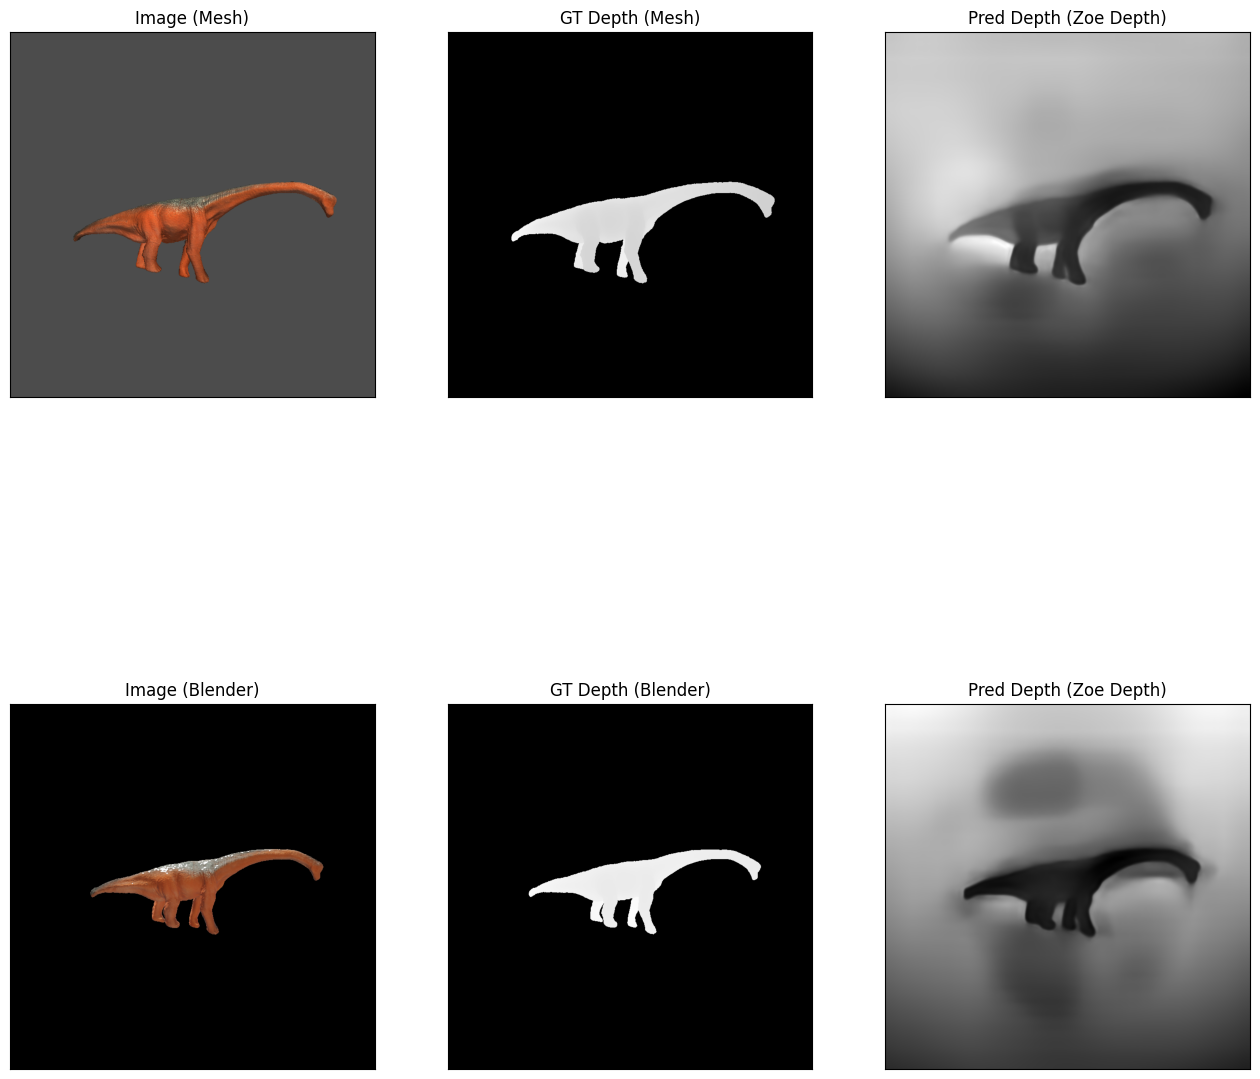

In [12]:
fig, axs = plt.subplots(2, 3, figsize=(16, 16))

viz_mesh_depth = normalize_img(mesh_depth)
viz_mesh_depth = torch.cat([viz_mesh_depth, viz_mesh_depth, viz_mesh_depth], dim=1)

viz_scanned_depth = normalize_img(scanned_depth)
viz_scanned_depth = torch.cat([viz_scanned_depth, viz_scanned_depth, viz_scanned_depth], dim=1)

fig_title = ["Image (Mesh)", "GT Depth (Mesh)", "Pred Depth (Zoe Depth)", "Image (Blender)", "GT Depth (Blender)", "Pred Depth (Zoe Depth)",]
axs = axs.flatten()
for i, (ax, img) in enumerate(zip(axs, [mesh_frame, viz_mesh_depth, mesh_torch_zoe_depth, scanned_frame, viz_scanned_depth, scanned_torch_zoe_depth])):
    ax.imshow(torch_to_pil(img))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(fig_title[i])


scanned_background_index = scanned_depth == torch.max(scanned_depth)
mesh_background_index = mesh_depth == torch.max(mesh_depth)

scanned_depth[scanned_background_index] = 0
mesh_depth[mesh_background_index] = 0

print("Perfect depth difference", torch.linalg.norm(mesh_depth[0][0] - mesh_torch_zoe_depth))
print("Scanned depth difference", torch.linalg.norm(scanned_depth[0][0] - scanned_torch_zoe_depth))